# 7. Reinforcement learning for Control 🐶

<a href="https://githubtocolab.com/edgarsmdn/MLCE_book/blob/main/07_RL_Control.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

```{attention} 
In this tutorial we are going to use the same CSTR example as in [tutorial notebook 6](https://edgarsmdn.github.io/MLCE_book/06_PID_tuning.html). Therefore, it is a great idea to first look at tutorial 6 to have the complete context.
```



## Goals of this exercise 🌟
- Perform reactor control using reinforcement learning
- Revise the concept of transfer learning
- Revise the concept of policy gradients


## A quick reminder ✅

Reinforcement Learning (RL) is an area of machine learning concerned with how intelligent agents ought to take actions in an environment in order to maximize the notion of cumulative reward. 

RL algorithms are particularly well suited to address sequential decision making problems under uncertainty, for example, they are generally applied to solve problems in a Markov decision process (MDP) setting. A control problem (just like reactor control) is a sequential decision making problem under uncertainty, where at every time-step the controller (agent in the RL context) must take an optimal (control) action, and it is hindered by process disturbances (uncertainty). There are many types of reinforcement leanring algorithms, in this notebook tutorial we will focus on **policy optimization** algorithms. 

We can define an RL agent as a controller that given a state ${\bf x}$ outputs the optimal action ${\bf u}$

$${\bf u}:=\pi({\bf x})$$

If the controller $\pi(\cdot)$ is parametrized, say by neural network weights $\boldsymbol{\theta}$, we can write 

$${\bf u}:=\pi({\bf x};\boldsymbol{\theta})$$

where ${\bf \theta}$ are parameters determined *a priori*. We could define the PID controller in this same fashion:

$$u:=\text{PID}(x;K_P,K_I,K_D)$$

In many cases, to fullfil the exploration - exploitation dilemma or in games, stochastic policies are used, which instead of outputting a single action ${\bf u}$, output a distributions over actions $p({\bf x};\boldsymbol{\theta})$. 

$${\bf u} \sim p({\bf x};\boldsymbol{\theta})$$

In practice, it is common to have a neural network output the moments (mean and variance), and to then draw an action from the distribution parametrized by this mean and variance

$$ \boldsymbol{ \mu }, \boldsymbol{ \Sigma } := p({\bf x};\boldsymbol{\theta})$$

$${\bf u} \sim \mathcal{N}(\boldsymbol{ \mu }, \boldsymbol{ \Sigma })$$

You can find a Taxonomy of RL Algorithms below.

```{figure} media/07_RL/algorithms.PNG
:alt: kNN
:width: 100%
:align: center

A broad classification of reinforcement learning algorithms. [source](https://spinningup.openai.com/en/latest/spinningup/rl_intro2.html)
```

In [333]:
import torch
import torch.nn.functional as Ffunctional
import copy
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from matplotlib.ticker import StrMethodFormatter
from pylab import grid
import time
import random
#import skopt
#from skopt import BayesSearchCV
#from skopt.space import Real, Integer

The code below corresponds to the CSTR model and parameters of tutorial 6.

In [367]:
#@title CSTR code from tutorial 6

eps  = np.finfo(float).eps

#######################
#  Distillation model #
#######################

def multistage_extraction_ode(x, t, u):
    #Based on Ingham pg 471 (449)
    #Solute and solvent extraction in 5 stage countercurrent extraction process
    #Maybe also change to include backmixing as per pg 475 (453)

    #Parameters
    Vl = 5 #Liquid volume in each stage
    Vg = 5 #Gas volume in each stage
    m = 1 #Equilibrium constant [-]
    Kla = 5 #Mass transfer capacity constant 1/hr 
    eq_exponent = 2 #Change the nonlinearity of the equilibrium relationship
    X0 = 0.6 #Feed concentration of liquid
    Y6 = 0.05 #Feed conc of gas


    ###Model Equations###

    ##States##
    #Xn - Concentration of solute in liquid pase of stage n [kg/m3]
    #Yn - Concentration of solute in gas phase of stage n [kg/m3]

    X1, Y1, X2, Y2, X3, Y3, X4, Y4, X5, Y5 = x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7], x[8], x[9]

    ##Inputs##
    #L - Liquid flowrate m3/hr
    #G - Gas flowrate m3/hr

    L, G = u[0], u[1]

    X1_eq = ((Y1**eq_exponent)/m)
    X2_eq = ((Y2**eq_exponent)/m)
    X3_eq = ((Y3**eq_exponent)/m)
    X4_eq = ((Y4**eq_exponent)/m)
    X5_eq = ((Y5**eq_exponent)/m)

    Q1 = Kla*(X1 - X1_eq)*Vl
    Q2 = Kla*(X2 - X2_eq)*Vl
    Q3 = Kla*(X3 - X3_eq)*Vl
    Q4 = Kla*(X4 - X4_eq)*Vl
    Q5 = Kla*(X5 - X5_eq)*Vl

    dxdt = [
        (1/Vl)*(L * (X0 - X1) - Q1),
        (1/Vg)*(G * (Y2 - Y1) + Q1),
        (1/Vl)*(L * (X1 - X2) - Q2),
        (1/Vg)*(G * (Y3 - Y2) + Q2),
        (1/Vl)*(L * (X2 - X3) - Q3),
        (1/Vg)*(G * (Y4 - Y3) + Q3),
        (1/Vl)*(L * (X3 - X4) - Q4),
        (1/Vg)*(G * (Y5 - Y4) + Q4),
        (1/Vl)*(L * (X4 - X5) - Q5),
        (1/Vg)*(G * (Y6 - Y5) + Q5), 
        ]

    return dxdt

data_res = {} 
# Initial conditions for the states
x0             = np.zeros(10)
x0[0]          = 0.55
x0[1]          = 0.3
x0[2]          = 0.45
x0[3]          = 0.25
x0[4]          = 0.4
x0[5]          = 0.20
x0[6]          = 0.35
x0[7]          = 0.15
x0[8]          = 0.25
x0[9]          = 0.1
data_res['x0'] = x0

# Time interval (min)
n             = 101 # number of intervals
tp            = 25 # process time (min)
t             = np.linspace(0,tp,n)
data_res['t'] = t
data_res['n'] = n

# Store results for plotting
X1 = np.zeros(len(t));      X1[0]  = x0[0]
Y1  = np.zeros(len(t));     Y1[0]  = x0[1]
X2  = np.zeros(len(t));     X2[0]  = x0[2]
Y2  = np.zeros(len(t));     Y2[0]  = x0[3]
X3  = np.zeros(len(t));     X3[0]  = x0[4]
Y3  = np.zeros(len(t));     Y3[0]  = x0[5]
X4  = np.zeros(len(t));     X4[0]  = x0[6]
Y4  = np.zeros(len(t));     Y4[0]  = x0[7]
X5  = np.zeros(len(t));     X5[0]  = x0[8]
Y5  = np.zeros(len(t));     Y5[0]  = x0[9]
L = np.zeros(len(t)-1);  
G = np.zeros(len(t)-1);

data_res['X1_dat'] = copy.deepcopy(X1)
data_res['Y1_dat'] = copy.deepcopy(Y1)
data_res['X2_dat'] = copy.deepcopy(X2)
data_res['Y2_dat'] = copy.deepcopy(Y2)
data_res['X3_dat'] = copy.deepcopy(X3)
data_res['Y3_dat'] = copy.deepcopy(Y3)
data_res['X4_dat'] = copy.deepcopy(X4)
data_res['Y4_dat'] = copy.deepcopy(Y4)
data_res['X5_dat'] = copy.deepcopy(X5)
data_res['Y5_dat'] = copy.deepcopy(Y5)
data_res['L_dat']  = copy.deepcopy(L)
data_res['G_dat']  = copy.deepcopy(G)

# noise level
noise             = 0.1
data_res['noise'] = noise

# control upper and lower bounds
data_res['L_ub']  = 500
data_res['L_lb']  = 5
data_res['G_ub']  = 1000
data_res['G_lb']  = 10
L_ub              = data_res['L_ub']
L_lb              = data_res['L_lb']
G_ub              = data_res['G_ub']
G_lb              = data_res['G_lb']

# desired setpoints
n_1                = int(n/2)
n_2                = n - n_1
X5_des             = [0.3 for i in range(n_1)] + [0.4 for i in range(n_2)]
#Xf_des             = [ for i in range(n_1)] + [ for i in range(n_2)]
Y1_des             = [0.3 for i in range(n_1)] + [0.3 for i in range(n_2)]
data_res['X5_des'] = X5_des
data_res['Y1_des'] = Y1_des

##################
# PID controller #
##################

def PID(Ks, x, x_setpoint, e_history):

    Ks    = np.array(Ks)
    Ks    = Ks.reshape(7, order='C')

    # K gains
    KpX5 = Ks[0]; KiX5 = Ks[1]; KdX5 = Ks[2]
    KpY1  = Ks[3]; KiY1  = Ks[4]; KdY1  = Ks[5]; 
    Kb   = Ks[6]
    # setpoint error
    e = x_setpoint - x
    # control action
    u  = KpX5*e[0] + KiX5*sum(e_history[:,0]) + KdX5*(e[0]-e_history[-1,0])
    u += KpY1*e[1] + KiY1*sum(e_history[:,1]) + KdY1*(e[1]-e_history[-1,1])
    u += Kb
    u[0]  = min(max(u[0],data_res['L_lb']),data_res['L_ub'])
    u[1]  = min(max(u[1],data_res['F_lb']),data_res['G_ub'])

    return u

In [375]:
#@title Ploting routines

####################################
# plot control actions performance #
####################################

def plot_simulation(X5_dat, Y1_dat, L_dat, G_dat, data_simulation):    # X1_dat, X2_dat, X3_dat, X4_dat, Y2_dat, Y3_dat, Y4_dat, Y5_dat,
    
    X5_des = data_simulation['X5_des']
    Y1_des = data_simulation['Y1_des']
    
    plt.figure(figsize=(8, 8))

    # plt.subplot(12,1,1)
    # plt.plot(t, np.median(X1_dat,axis=1), 'r-', lw=3)
    # plt.gca().fill_between(t, np.min(X1_dat,axis=1), np.max(X1_dat,axis=1), 
    #                        color='r', alpha=0.2)
    # plt.ylabel('X1 (mol/mol)')
    # plt.xlabel('Time (min)')
    # plt.legend(['Liquid phase mole fraction in first stage'],loc='best')
    # plt.xlim(min(t), max(t))
# 
    # plt.subplot(12,1,2)
    # plt.plot(t, np.median(X2_dat,axis=1), 'r-', lw=3)
    # plt.gca().fill_between(t, np.min(X2_dat,axis=1), np.max(X2_dat,axis=1), 
    #                        color='r', alpha=0.2)
    # plt.ylabel('X2 (mol/mol)')
    # plt.xlabel('Time (min)')
    # plt.legend(['Liquid phase mole fraction in second stage'],loc='best')
    # plt.xlim(min(t), max(t))
# 
    # plt.subplot(12,1,3)
    # plt.plot(t, np.median(X3_dat,axis=1), 'r-', lw=3)
    # plt.gca().fill_between(t, np.min(X3_dat,axis=1), np.max(X3_dat,axis=1), 
    #                        color='r', alpha=0.2)
    # plt.ylabel('X3 (mol/mol)')
    # plt.xlabel('Time (min)')
    # plt.legend(['Liquid phase mole fraction in third stage'],loc='best')
    # plt.xlim(min(t), max(t))
# 
    # plt.subplot(12,1,4)
    # plt.plot(t, np.median(X4_dat,axis=1), 'r-', lw=3)
    # plt.gca().fill_between(t, np.min(X4_dat,axis=1), np.max(X4_dat,axis=1), 
    #                        color='r', alpha=0.2)
    # plt.ylabel('X4 (mol/mol)')
    # plt.xlabel('Time (min)')
    # plt.legend(['Liquid phase mole fraction in fourth stage'],loc='best')
    # plt.xlim(min(t), max(t))

    plt.subplot(4,1,1)
    plt.plot(t, np.median(X5_dat,axis=1), 'r-', lw=3)
    plt.gca().fill_between(t, np.min(X5_dat,axis=1), np.max(X5_dat,axis=1), 
                           color='r', alpha=0.2)
    plt.step(t, X5_des, '--', lw=1.5, color='black')
    plt.ylabel('X5 (mol/mol)')
    plt.xlabel('Time (min)')
    plt.legend(['Liquid phase mole fraction in fifth stage'],loc='best')
    plt.xlim(min(t), max(t))

    plt.subplot(4,1,2)
    plt.plot(t, np.median(Y1_dat,axis=1), 'c-', lw=3)
    plt.gca().fill_between(t, np.min(Y1_dat,axis=1), np.max(Y1_dat,axis=1), 
                           color='c', alpha=0.2)
    plt.step(t, Y1_des, '--', lw=1.5, color='black')
    plt.ylabel('Y1 (mol/mol)')
    plt.xlabel('Time (min)')
    plt.legend(['Gas phase mole fraction in first stage'],loc='best')
    plt.xlim(min(t), max(t))

    # plt.subplot(12,1,7)
    # plt.plot(t, np.median(Y2_dat,axis=1), 'r-', lw=3)
    # plt.gca().fill_between(t, np.min(Y2_dat,axis=1), np.max(Y2_dat,axis=1), 
    #                        color='r', alpha=0.2)
    # plt.ylabel('Y2 (mol/mol)')
    # plt.xlabel('Time (min)')
    # plt.legend(['Gas phase mole fraction in second stage'],loc='best')
    # plt.xlim(min(t), max(t))
# 
    # plt.subplot(12,1,8)
    # plt.plot(t, np.median(Y3_dat,axis=1), 'r-', lw=3)
    # plt.gca().fill_between(t, np.min(Y3_dat,axis=1), np.max(Y3_dat,axis=1), 
    #                        color='r', alpha=0.2)
    # plt.ylabel('Y3 (mol/mol)')
    # plt.xlabel('Time (min)')
    # plt.legend(['Gas phase mole fraction in third stage'],loc='best')
    # plt.xlim(min(t), max(t))
# 
    # plt.subplot(12,1,9)
    # plt.plot(t, np.median(Y4_dat,axis=1), 'r-', lw=3)
    # plt.gca().fill_between(t, np.min(Y4_dat,axis=1), np.max(Y4_dat,axis=1), 
    #                        color='r', alpha=0.2)
    # plt.ylabel('Y4 (mol/mol)')
    # plt.xlabel('Time (min)')
    # plt.legend(['Gas phase mole fraction in fourth stage'],loc='best')
    # plt.xlim(min(t), max(t))
# 
    # plt.subplot(12,1,10)
    # plt.plot(t, np.median(Y5_dat,axis=1), 'r-', lw=3)
    # plt.gca().fill_between(t, np.min(Y5_dat,axis=1), np.max(Y5_dat,axis=1), 
    #                        color='r', alpha=0.2)
    # plt.ylabel('Y5 (mol/mol)')
    # plt.xlabel('Time (min)')
    # plt.legend(['Gas phase mole fraction in fifth stage'],loc='best')
    # plt.xlim(min(t), max(t))


    plt.subplot(4,1,3)
    plt.step(t[1:], np.median(L_dat,axis=1), 'b--', lw=3)
    plt.ylabel('L (m3/hr)')
    plt.xlabel('Time (min)')
    plt.legend(['Liquid flowrate in system'],loc='best')
    plt.xlim(min(t), max(t))
    
    plt.subplot(4,1,4)
    plt.step(t[1:], np.median(G_dat,axis=1), 'b--', lw=3)
    plt.ylabel('G (m3/hr)')
    plt.xlabel('Time (min)')
    plt.legend(['Gas flowrate in system'],loc='best')
    plt.xlim(min(t), max(t))


    plt.tight_layout()
    plt.show()

##################
# Training plots #
##################

def plot_training(data_simulation, repetitions):
    t        = data_simulation['t'] 
    X5_train = np.array(data_simulation['X5_train'])
    Y1_train = np.array(data_simulation['Y1_train'])
    L_train = np.array(data_simulation['L_train'])
    G_train = np.array(data_simulation['G_train'])
    X5_des   = data_simulation['X5_des']
    Y1_des    = data_simulation['Y1_des']

    c_    = [(repetitions - float(i))/repetitions for i in range(repetitions)]

    plt.figure(figsize=(8, 5))

    plt.subplot(3,1,1)
    for run_i in range(repetitions):
        plt.plot(t, X5_train[run_i,:], 'r-', lw=1, alpha=c_[run_i])
    plt.step(t, X5_des, '--', lw=1.5, color='black')
    plt.ylabel('X5 (mol/mol)')
    plt.xlabel('Time (min)')
    plt.legend(['Liquid mole fraction in fifth stage'],loc='best')
    plt.title('Training plots')
    plt.xlim(min(t), max(t))
    grid(True)

    plt.subplot(3,1,2)
    for run_i in range(repetitions):
        plt.plot(t, Y1_train[run_i,:], 'c-', lw=1, alpha=c_[run_i])
    plt.step(t, Y1_des, '--', lw=1.5, color='black')
    plt.ylabel('Y1 (mol/mol)')
    plt.xlabel('Time (min)')
    plt.legend(['Gas mole fraction in first stage'],loc='best')
    plt.xlim(min(t), max(t))
    grid(True)

    plt.subplot(3,1,3)
    for run_i in range(repetitions):
        plt.step(t[1:], L_train[run_i,:], 'b--', lw=1, alpha=c_[run_i])
    plt.ylabel('L (m3/hr)')
    plt.xlabel('Time (min)')
    plt.legend(['Liquid flowrate in system'],loc='best')
    plt.xlim(min(t), max(t))
    grid(True)
    
    
    plt.tight_layout()

    plt.show()

#####################
# Convergence plots #
#####################

def plot_convergence(Xdata, best_Y, Objfunc=None):
    '''
    Plots to evaluate the convergence of standard Bayesian optimization algorithms
    '''
    ## if f values are not given
    f_best  = 1e8
    if best_Y==None: 
        best_Y = []
        for i_point in range(Xdata.shape[0]):
            f_point = Objfunc(Xdata[i_point,:], collect_training_data=False)
            if f_point < f_best:
                f_best = f_point 
            best_Y.append(f_best)
        best_Y = np.array(best_Y)

    n = Xdata.shape[0]
    aux = (Xdata[1:n,:]-Xdata[0:n-1,:])**2
    distances = np.sqrt(aux.sum(axis=1))

    ## Distances between consecutive x's
    plt.figure(figsize=(9,3))
    plt.subplot(1, 2, 1)
    plt.plot(list(range(n-1)), distances, '-ro')
    plt.xlabel('Iteration')
    plt.ylabel('d(x[n], x[n-1])')
    plt.title('Distance between consecutive x\'s')
    plt.xlim(0, n)
    grid(True)

    # Best objective value found over iterations
    plt.subplot(1, 2, 2)
    plt.plot(list(range(n)), best_Y,'-o')
    plt.title('Value of the best selected sample')
    plt.xlabel('Iteration')
    plt.ylabel('Best y')
    grid(True)
    plt.xlim(0, n)
    plt.tight_layout()
    plt.show()

#####################
# Algorithm performance plots #
#####################

def performance_plots(iterations, time, gbest, multiruns=False):
    
    iterations = list(range(1, len(gbest)+1))  
    
    plt.figure(figsize=(8, 8))

    plt.subplot(2,1,1)
    plt.plot(iterations, gbest, 'r-')
    if multiruns == True:
        plt.plot(iterations, np.median(gbest,axis=1), 'r-')
        plt.gca().fill_between(iterations, np.min(gbest,axis=1), np.max(gbest,axis=1), 
                               color='r', alpha=0.2)
    plt.ylabel('Best reward')
    plt.xlabel('Iterations')
    plt.title('Best Reward vs Iterations')
    plt.xlim(min(iterations), max(iterations))
    plt.yscale('log')



    plt.subplot(2,1,2)
    plt.plot(time, gbest, 'b-')
    if multiruns == True:
        plt.plot(time, np.median(gbest,axis=1), 'b-')
        plt.gca().fill_between(time, np.min(gbest,axis=1), np.max(gbest,axis=1), 
                               color='b', alpha=0.2)
    plt.ylabel('Best reward')
    plt.xlabel('Time (s)')
    plt.title('Best Reward vs Time')
    plt.xlim(min(time), max(time))
    plt.yscale('log')


    plt.tight_layout()

    plt.show()




    

## Stochastic Policy Search 🎲

### Policy network

In the same way as we used data-driven optimization to tune the gains $K_P,K_I,K_D$ in the PID controllers (cf. [tutorial notebook 6](https://edgarsmdn.github.io/MLCE_book/06_PID_tuning.html)), we can use the same approach to tune (or train) the parameters (or weights) $\boldsymbol{\theta}$ of a neural network. 

There is research that suggest that evolutionary (or stochastic search in general) algorithms can be as good (or better in some contexts) than traditional techniques, for more details see [Evolution Strategies as a Scalable Alternative to Reinforcement Learning](https://openai.com/research/evolution-strategies), the paper can be found [here](https://arxiv.org/abs/1703.03864).

The difference here, with respect to the controller tuning that we perform on [tutorial notebook 6](https://edgarsmdn.github.io/MLCE_book/06_PID_tuning.html) is that the neural networks have many parameters and the number of iterations needed are relatively high, and therefore, model/surrogate-based data-driven optimization methods do not scale as well and might not be the best choice. Therefore, stochastic search optimization methods (e.g. genetic algorithms, particle swarm optimization) can be a good alternative. You can check some pedagogical implementations [here](https://edgarsmdn.github.io/projects/stochastic_optimization_algorithms/).

In the following section we build a relatively simple neural network controller in PyTorch

$${\bf u}:=\pi({\bf x};\boldsymbol{\theta})$$

and hard code a simple stochastic search algorithm (it is a combination of random search and local random search) to manipulate the weights $\boldsymbol{\theta}$, evaluate the performance of the current weight values, and iterate.

**Neural Network Controller Training Algorithm**

*Initialization*

Collect $d$ initial datapoints $\mathcal{D}=\{(\hat{f}^{(j)}=\sum_{k=0}^{k=T_f} (e(k))^2,~ \boldsymbol{\theta}^{(j)}) \}_{j=0}^{j=d}$ by simulating $x(k+1) = f(x(\cdot),u(\cdot))$ for different values of $\boldsymbol{\theta}^{(j)}$, set a small radious of search $r$

*Main loop*

1. *Repeat*
2. $~~~~~~$ Choose best current known parameter value $\boldsymbol{\theta}^*$.
3. $~~~~~~$ Sample $n_s$ values around $\boldsymbol{\theta}^*$, that are at most some distance $r$, $\bar{\boldsymbol{\theta}}^{(0)},...,\bar{\boldsymbol{\theta}}^{(n_s)}$
3. $~~~~~~$ Simulate new values  $ x(k+1) = f(x(k),u(\bar{\boldsymbol{\theta}}^{(i)};x(k))), ~ k=0,...,T_f-1, i=0,...,n_s $
4. $~~~~~~$ Compute $\hat{f}^{(i)}=\sum_{k=0}^{k=T_f} (e(k))^2, i=0,...,n_s$.
5. $~~~~~~$ **if** $\bar{\boldsymbol{\theta}}^{\text{best}}$ is better than $\boldsymbol{\theta}^*$, then $ \boldsymbol{\theta}^* \leftarrow \bar{\boldsymbol{\theta}}^{\text{best}}$, **else** $ r \leftarrow r\gamma$, where $ 0 < \gamma <1 $ 
6. until stopping criterion is met.

Remarks: 
* The initial collection of $d$ points is generally done by some space filling (e.g. [Latin Hypercube](https://en.wikipedia.org/wiki/Latin_hypercube_sampling), [Sobol Sequence](https://en.wikipedia.org/wiki/Sobol_sequence)) procedure.

First, let's create a neural network in PyTorch that has two hidden layers, one being double the size of the input layer and the other double the size of the output layer. We will use the activation functions [LeakyReLU](https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html) and [ReLU6](https://pytorch.org/docs/stable/generated/torch.nn.ReLU6.html). If you want a more gentle introduction to neural nets in Pytorch, check the [tutorial notebook 4](https://edgarsmdn.github.io/MLCE_book/04_DNN_VLE.html).

In [356]:
##################
# Policy Network #
##################

class Net(torch.nn.Module):
  # in current form this is a linear function (wouldn't expect great performance here)
    def __init__(self, **kwargs):
        super(Net, self).__init__()

        self.dtype    = torch.float

        # Unpack the dictionary 
        self.args     = kwargs

        # Get info of machine
        self.use_cuda = torch.cuda.is_available() 
        self.device   = torch.device("cpu")

        # Define ANN topology 
        self.input_size = self.args['input_size']
        self.output_sz  = self.args['output_size']
        self.hs1        = self.input_size*2
        self.hs2        = self.hs1
        self.hs3        = self.output_sz*2 

        # Define layers 
        self.hidden1 = torch.nn.Linear(self.input_size, self.hs1)
        self.hidden2 = torch.nn.Linear(self.hs1, self.hs2)
        self.hidden3 = torch.nn.Linear(self.hs2, self.hs3)
        self.output  = torch.nn.Linear(self.hs3, self.output_sz)

    def forward(self, x):
        #x = torch.tensor(x.view(1,1,-1)).float() # re-shape tensor
        x = x.view(1, 1, -1).float()
        y = Ffunctional.elu(self.hidden1(x), 0.1)
        y = Ffunctional.elu(self.hidden2(y), 0.1)
        y = Ffunctional.elu(self.hidden3(y), 0.1)
        y = Ffunctional.relu6(self.output(y))   # range (0,6)

        return y

In [337]:
def simulate_DIST(u_traj, data_simulation, repetitions):
    '''
    u_traj: Trajectory of input values
    data_simulation: Dictionary of simulation data
    repetitions: Number of simulations to perform
    '''
    # loading process operations
    X1    = copy.deepcopy(data_simulation['X1_dat']) 
    Y1    = copy.deepcopy(data_simulation['Y1_dat'])
    X2    = copy.deepcopy(data_simulation['X2_dat'])
    Y2    = copy.deepcopy(data_simulation['Y2_dat'])
    X3    = copy.deepcopy(data_simulation['X3_dat'])
    Y3    = copy.deepcopy(data_simulation['Y3_dat'])
    X4    = copy.deepcopy(data_simulation['X4_dat'])
    Y4    = copy.deepcopy(data_simulation['Y4_dat'])
    X5    = copy.deepcopy(data_simulation['X5_dat'])
    Y5    = copy.deepcopy(data_simulation['Y5_dat'])
    x0    = copy.deepcopy(data_simulation['x0'])
    t     = copy.deepcopy(data_simulation['t'])     
    noise = data_simulation['noise'] 
    n     = copy.deepcopy(data_simulation['n']) 
    
    # control preparation
    u_traj = np.array(u_traj)
    u_traj = u_traj.reshape(2,n-1, order='C')
    L      = u_traj[0,:]
    G      = u_traj[1,:]

    # creating lists
    X1_dat    = np.zeros((len(t),repetitions))
    Y1_dat    = np.zeros((len(t),repetitions))
    X2_dat    = np.zeros((len(t),repetitions))
    Y2_dat    = np.zeros((len(t),repetitions))
    X3_dat    = np.zeros((len(t),repetitions))
    Y3_dat    = np.zeros((len(t),repetitions))
    X4_dat    = np.zeros((len(t),repetitions))
    Y4_dat    = np.zeros((len(t),repetitions))
    X5_dat    = np.zeros((len(t),repetitions))
    Y5_dat    = np.zeros((len(t),repetitions))
    L_dat    = np.zeros((len(t)-1,repetitions))
    G_dat    = np.zeros((len(t)-1,repetitions))
    u_mag_dat = np.zeros((len(t)-1,repetitions))  
    u_cha_dat = np.zeros((len(t)-2,repetitions))

    # multiple repetitions
    for rep_i in range(repetitions):
        x   = copy.deepcopy(data_simulation['x0'])

        # main process simulation loop
        for i in range(len(t)-1):
            ts      = [t[i],t[i+1]]
            # integrate system
            y       = odeint(multistage_extraction_ode,x,ts,args=(u_traj[:,i],))
            # adding stochastic behaviour 
            s       = np.random.uniform(low=-1, high=1, size=10)
            X1[i+1]      = max(min((y[-1][0] + noise*s[0]*0.1), 1), 0)   
            Y1[i+1]      = max(min((y[-1][1] + noise*s[1]*0.1), 1), 0) 
            X2[i+1]      = max(min((y[-1][2] + noise*s[2]*0.1), 1), 0) 
            Y2[i+1]      = max(min((y[-1][3] + noise*s[3]*0.1), 1), 0) 
            X3[i+1]      = max(min((y[-1][4] + noise*s[4]*0.1), 1), 0) 
            Y3[i+1]      = max(min((y[-1][5] + noise*s[5]*0.1), 1), 0) 
            X4[i+1]      = max(min((y[-1][6] + noise*s[6]*0.1), 1), 0) 
            Y4[i+1]      = max(min((y[-1][7] + noise*s[7]*0.1), 1), 0) 
            X5[i+1]      = max(min((y[-1][8] + noise*s[8]*0.1), 1), 0)
            Y5[i+1]      = max(min((y[-1][9] + noise*s[9]*0.1), 1), 0)   
            # state update
            x[0]         = X1[i+1]
            x[1]         = Y1[i+1]
            x[2]         = X2[i+1]
            x[3]         = Y2[i+1]
            x[4]         = X3[i+1]
            x[5]         = Y3[i+1]
            x[6]         = X4[i+1]
            x[7]         = Y4[i+1]
            x[8]         = X5[i+1]
            x[9]         = Y5[i+1]

        # data collection
        X1_dat[:,rep_i]    = copy.deepcopy(X1)
        Y1_dat[:,rep_i]    = copy.deepcopy(Y1)
        X2_dat[:,rep_i]    = copy.deepcopy(X2)
        Y2_dat[:,rep_i]    = copy.deepcopy(Y2)
        X3_dat[:,rep_i]    = copy.deepcopy(X3)
        Y3_dat[:,rep_i]    = copy.deepcopy(Y3)
        X4_dat[:,rep_i]    = copy.deepcopy(X4)
        Y4_dat[:,rep_i]    = copy.deepcopy(Y4)
        X5_dat[:,rep_i]    = copy.deepcopy(X5)
        Y5_dat[:,rep_i]    = copy.deepcopy(Y5)
        L_dat[:,rep_i]     = copy.deepcopy(L)
        G_dat[:,rep_i]     = copy.deepcopy(G)

    return X1_dat, Y1_dat, X2_dat, Y2_dat, X3_dat, Y3_dat, X4_dat, Y4_dat, X5_dat, Y5_dat, L_dat, G_dat

[0.53, 0.22, 0.47, 0.19, 0.42, 0.15, 0.38, 0.12, 0.35, 0.09, 0, 0]
[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]


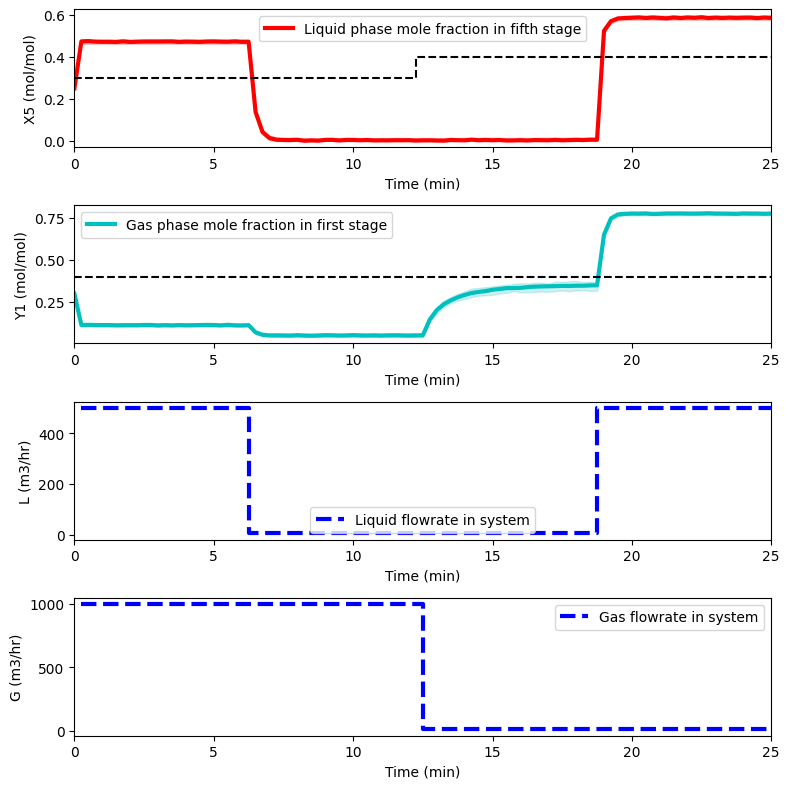

In [338]:
# Step cooling temperature to 295
u_example = np.zeros((2, n-1))
# for i in range(n-1):
#     u_example[0, i] = np.random.randint(5, 500)
#     u_example[1, i] = np.random.randint(10, 1000)

n_1 = int(n/4)
n_2 = int(n/4)
n_3 = int(n/4)
n_4 = n - n_1 - n_2 - n_3 -1

u_example[0, :] = [500 for i in range(n_1)] + [5 for i in range(n_2)] + [5 for i in range(n_3)] + [500 for i in range(n_4)] # Liquid flowrate
u_example[1, :] = [1000 for i in range(n_1)] + [1000 for i in range(n_2)] + [10 for i in range(n_3)] + [10 for i in range(n_4)] # Gas flowrate

# Simulation
X1_dat, Y1_dat, X2_dat, Y2_dat, X3_dat, Y3_dat, X4_dat, Y4_dat, X5_dat, Y5_dat, L_dat, G_dat = simulate_DIST(u_example, data_res, 100)

means = [0.53, 0.22, 0.47, 0.19, 0.42, 0.15, 0.38, 0.12, 0.35, 0.09, 0, 0]
ranges = [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]

#means = [np.mean(np.mean(X1_dat, axis=1),axis=0), np.mean(np.mean(Y1_dat, axis=1),axis=0), np.mean(np.mean(X2_dat, axis=1),axis=0), np.mean(np.mean(Y2_dat, axis=1),axis=0), np.mean(np.mean(X3_dat, axis=1),axis=0), np.mean(np.mean(Y3_dat, axis=1),axis=0), np.mean(np.mean(X4_dat, axis=1),axis=0), np.mean(np.mean(Y4_dat, axis=1),axis=0), np.mean(np.mean(X5_dat, axis=1),axis=0), np.mean(np.mean(Y5_dat, axis=1),axis=0)]
#ranges = [np.max(np.max(X1_dat, axis=0)-np.min(X1_dat, axis=0)), np.max(np.max(Y1_dat, axis=0)-np.min(Y1_dat, axis=0)),np.max(np.max(X2_dat, axis=0)-np.min(X2_dat, axis=0)), np.max(np.max(Y2_dat, axis=0)-np.min(Y2_dat, axis=0)), np.max(np.max(X3_dat, axis=0)-np.min(X3_dat, axis=0)), np.max(np.max(Y3_dat, axis=0)-np.min(Y3_dat, axis=0)), np.max(np.max(X4_dat, axis=0)-np.min(X4_dat, axis=0)), np.max(np.max(Y4_dat, axis=0)-np.min(Y4_dat, axis=0)), np.max(np.max(X5_dat, axis=0)-np.min(X5_dat, axis=0)), np.max(np.max(Y5_dat, axis=0)-np.min(Y5_dat, axis=0))]
print(means)
print(ranges)
# Plot the results
plot_simulation(X5_dat, Y1_dat, L_dat, G_dat, data_res)

We normalize the inputs and states

In [339]:
# normalization for states and actions
data_res['x_norm'] = np.array([means, ranges]) # [mean],[range]
data_res['u_norm'] = np.array([[495/6, 990/6],[5, 10]])    # [range/6],[bias]

Now, let's create the objective function for the policy network. 

```{tip} Notice the difference between this objective function and the objective function use in [tutorial 6](https://edgarsmdn.github.io/MLCE_book/04_DNN_VLE.html). We have included a conditional to switch between algorithms.
```


In [363]:
def J_PolicyDIST(policy, data_res=data_res, policy_alg='PID', 
                 collect_training_data=True, traj=False, episode=False):
    
    # load data
    X1    = copy.deepcopy(data_res['X1_dat'])
    Y1    = copy.deepcopy(data_res['Y1_dat'])
    X2    = copy.deepcopy(data_res['X2_dat'])
    Y2    = copy.deepcopy(data_res['Y2_dat'])
    X3    = copy.deepcopy(data_res['X3_dat'])
    Y3    = copy.deepcopy(data_res['Y3_dat'])
    X4    = copy.deepcopy(data_res['X4_dat'])
    Y4    = copy.deepcopy(data_res['Y4_dat'])
    X5    = copy.deepcopy(data_res['X5_dat'])
    Y5    = copy.deepcopy(data_res['Y5_dat'])
    L     = copy.deepcopy(data_res['L_dat'])
    G     = copy.deepcopy(data_res['G_dat'])
    t     = copy.deepcopy(data_res['t']) 
    x0    = copy.deepcopy(data_res['x0'])
    noise = data_res['noise']
    

    # setpoints      
    X5_des = data_res['X5_des']; Y1_des = data_res['Y1_des']
    
    # upper and lower bounds
    L_ub  = data_res['L_ub'];  L_lb  = data_res['L_lb']
    G_ub  = data_res['G_ub'];  G_lb  = data_res['G_lb']
    
    # normalized states and actions
    x_norm = data_res['x_norm']; u_norm = data_res['u_norm'];

    # initiate
    x         = copy.deepcopy(data_res['x0'])
    e_history = []

    # log probs
    if policy_alg == 'PG_RL':
      log_probs = [None for i in range(len(t)-1)]
    
    # Simulate column
    for i in range(len(t)-1):
        # delta t
        ts      = [t[i],t[i+1]]
        # desired setpoint
        x_sp    = np.array([X5_des[i], Y1_des[i]]) # since we only care about controlling the first and last variables, set the s.p. of the others equal to the process variable
        ctrl_x  = np.array([x[8], x[1]])
        #### PID ####
        if policy_alg == 'PID':
          if i == 0:
            Tc[i] = PID(policy, x, x_sp, np.array([[0,0]]))
          else:
            Tc[i] = PID(policy, x, x_sp, np.array(e_history))

        # --------------> New compared to tutorial 6 <-------------------
        #### Stochastic Policy Search ####
        elif policy_alg == 'SPS_RL':
          xk      = np.hstack((x,x_sp-ctrl_x))
          # state preprocesing
          xknorm       = (xk-x_norm[0])/x_norm[1]
          xknorm_torch = torch.tensor(xknorm)
          # compute u_k from policy
          # print('normalised state',xknorm)
          mean_uk      = policy(xknorm_torch).detach().numpy()
          u_k          = np.reshape(mean_uk, (1, 2))
          u_k          = u_k*u_norm[0] + u_norm[1]
          #print("The first value for u_k is:", u_k)
          u_k          = u_k[0]
          #print("The second value for u_k is:", u_k)
          u_k[0]       = min(max(u_k[0], L_lb), L_ub)
          u_k[1]       = min(max(u_k[1], G_lb), G_ub)
          #print("The third value for u_k is:", u_k)
          L[i]         = u_k[0]
          G[i]         = u_k[1]
          eqn_inputs   = (L[i], G[i])
          
          

        #### Policy Gradients #### 
        # See next section for the explanation on Policy gradients!
        elif policy_alg == 'PG_RL':
          xk      = np.hstack((x,x_sp-x))
          # state preprocesing
          xknorm       = (xk-x_norm[0])/x_norm[1]
          xknorm_torch = Tensor(xknorm)
          # compute u_k distribution
          m, s                      = policy(xknorm_torch)[0,0]
          s                         = s + eps
          mean_uk, std_uk           = mean_std(m, s)
          u_k, logprob_k, entropy_k = select_action(mean_uk, std_uk)
          u_k                       = np.reshape(u_k.numpy(), (nu))
          # hard bounds on inputs
          u_k                       = min(max(u_k, Tc_lb), Tc_ub)
          Tc[i]                     = u_k
          log_probs[i] = logprob_k
        # ----------------------------------------------------------------

        # simulate system
        y            = odeint(multistage_extraction_ode,x,ts,args=(eqn_inputs,))
        # add process disturbance
        s            = np.random.uniform(low=-1, high=1, size=2)
        X1[i+1]      = max(min(y[-1][0] + noise*s[0]*0.1, 1), 0)   
        Y1[i+1]      = max(min(y[-1][1] + noise*s[0]*0.1, 1), 0) 
        X2[i+1]      = max(min(y[-1][2] + noise*s[0]*0.1, 1), 0) 
        Y2[i+1]      = max(min(y[-1][3] + noise*s[0]*0.1, 1), 0) 
        X3[i+1]      = max(min(y[-1][4] + noise*s[0]*0.1, 1), 0) 
        Y3[i+1]      = max(min(y[-1][5] + noise*s[0]*0.1, 1), 0) 
        X4[i+1]      = max(min(y[-1][6] + noise*s[0]*0.1, 1), 0) 
        Y4[i+1]      = max(min(y[-1][7] + noise*s[0]*0.1, 1), 0) 
        X5[i+1]      = max(min(y[-1][8] + noise*s[1]*0.1, 1), 0)
        Y5[i+1]      = max(min(y[-1][9] + noise*s[1]*0.1, 1), 0)
        # state update
        x[0]         = X1[i+1]
        x[1]         = Y1[i+1]
        x[2]         = X2[i+1]
        x[3]         = Y2[i+1]
        x[4]         = X3[i+1]
        x[5]         = Y3[i+1]
        x[6]         = X4[i+1]
        x[7]         = Y4[i+1]
        x[8]         = X5[i+1]
        x[9]         = Y5[i+1]
        # compute tracking error
        ctrl_x = np.array([x[8], x[1]])
        e_history.append((x_sp-ctrl_x))

    # == objective == #
    # tracking error
    error = np.abs(np.array(e_history)[:,0])/ranges[8]+np.abs(np.array(e_history)[:,1])/ranges[1]
    # penalize magnitude of control action
    u_mag = np.abs(L[:]-L_lb)/20+np.abs(G[:]-G_lb)/20
    u_mag = u_mag*0 # min 50
    # penalize change in control action
    u_cha = np.abs(L[1:]-L[0:-1])/20+np.abs(G[1:]-G[0:-1])/20
    u_cha = u_cha*0 # min 10 
    
    # collect data for plots
    if collect_training_data:
        data_res['X1_train'].append(X1)
        data_res['Y1_train'].append(Y1)
        data_res['X2_train'].append(X2)
        data_res['Y2_train'].append(Y2)
        data_res['X3_train'].append(X3)
        data_res['Y3_train'].append(Y3)
        data_res['X4_train'].append(X4)
        data_res['Y4_train'].append(Y4)
        data_res['X5_train'].append(X5)
        data_res['Y5_train'].append(Y5)
        data_res['L_train'].append(L)
        data_res['G_train'].append(G)
        data_res['err_train'].append(error)
        data_res['u_mag_train'].append(u_mag)
        data_res['u_cha_train'].append(u_cha)

    # sums
    error = np.sum(error)
    u_mag = np.sum(u_mag)
    u_cha = np.sum(u_cha)

    if episode:
      # See next section for the explanation on Policy gradients!
      sum_logprob = sum(log_probs)
      reward      = -(error + u_mag + u_cha)
      return reward, sum_logprob
    
    if traj:
      return X5, Y1, L, G
    else:
      return error + u_mag + u_cha # u_mag is the culprit now


As mentioned above, we are going to use a stochastic search algorithm that combines random search with local random search to optimize the policy network.

The code below has two main elements:

**Random Search Step**: During this step neural network weights are sampled uniformely (given some bounds). Each set of parameters is evaluated (a simulation is run), and the parameter set that performed best is passed to the next step.

An illustration of how Random Search would look in a 2-dimensional space is shown below

```{figure} media/07_RL/random_search.PNG
:alt: kNN
:width: 75%
:align: center

An illustration of the random search algorithm. [source](https://commons.wikimedia.org/wiki/File:Hyperparameter_Optimization_using_Random_Search.svg)
```

**Local Search Step**: This step starts from the best parameter values found by the *Random Search Step*. Subsequently it does a random search close by the best value found (hence termed stocastic local search). Additionally, if after some number of interations a better function value has not been found (also via simulating the system), the radius of search is reduced. 

An illustration of how Local search would look in a 2-dimensional space is shown below

```{figure} media/07_RL/local_random_search.PNG
:alt: kNN
:width: 70%
:align: center

An illustration of the local search algorithm.
```

By combining a 'global search' strategy (Random search) and a 'local search' strategy (Local search) we balance exploration and exploitation which is a key concept in reinforcement learning.

In [358]:
#######################
# auxiliary functions #
#######################

def sample_uniform_params(params_prev, param_max, param_min):
    params = {k: torch.rand(v.shape)* (param_max - param_min) + param_min \
              for k, v in params_prev.items()}              
    return params

def sample_local_params(params_prev, param_max, param_min):
    params = {k: torch.rand(v.shape)* (param_max - param_min) + param_min + v \
              for k, v in params_prev.items()}              
    return params

def extract_NN_values(list_of_params):
    rows_tensors = []
    for params_dict in list_of_params:
        layer_shapes = []
        list_tensors = []
        layer_sizes = []
        for tensor in params_dict.values():
            list_tensors.append(torch.flatten(tensor))
            layer_sizes.append(torch.numel(tensor))
            layer_shapes.append(tensor.size())
        row_tensors = torch.cat(list_tensors)
        rows_tensors.append(row_tensors)
    mat_tensors = torch.stack(rows_tensors)
    return mat_tensors, layer_sizes, layer_shapes
    
def convert_to_NN_dict(tensor, layer_sizes, layer_shapes, params):
    split_indices = [sum(layer_sizes[0:i+1]) for i in range(len(layer_sizes))]
    NN_values = torch.tensor_split(tensor.squeeze(), split_indices, dim=0)
    NN_values_reshaped = [torch.reshape(NN_values[i], layer_shapes[i]) for i in range(len(layer_shapes))]
    dict_names = list(params.keys())
    dict_params = {dict_names[i]: NN_values_reshaped[i] for i in range(len(dict_names))}
    return dict_params
    


###################
# Genetic Algorithm
###################
    
def GeneticSearch(lower_bound=-5, upper_bound=5, mutation_rate=0.1, iterations=12, sample_size=10):
    
    start = time.time()
    gbest_history = []
    time_axis = []

    # problem initialisaion
    nu = 2
    nx = 9
    hyparams = {'input_size': nx+2, 'output_size': nu} # include setpoints +8
    n_steps = data_res['n']
    
    # policy initialisation
    policy_net = Net(**hyparams)
    params     = policy_net.state_dict()
    param_max  = 5# 1.5
    param_min  = -5#-1.5
    
    # initialise population
    population = []
    
    
    # initialise inputs
    for i in range(sample_size):
        member = sample_uniform_params(params, lower_bound, upper_bound)
        population.append(copy.deepcopy(member))
        
    #print("Population before:", population)
        
    for i in range(iterations+1):
        pop_tensor, layer_sizes, layer_shapes = extract_NN_values(population)
        fun_population = []
        print("Iteration", i)
        for j in range(len(population)):
            current_params = population[j] # fetch current NN parameter set
            policy_net.load_state_dict(current_params) # load set into NN
            reward = J_PolicyCSTR(policy_net, collect_training_data=True, 
                              policy_alg='SPS_RL') # evaluate NN in the controller simulation
            fun_population.append(reward) # add reward to the corresponding list
        fitness_scores = [1/value for value in fun_population] # evaluate the fitness score for each set of params
        total_fitness = sum(fitness_scores) # calculate total fitness score
        best_index = fitness_scores.index(max(fitness_scores))
        best_guess = pop_tensor[best_index, :]
        new_generation = [best_guess] # it automatically becomes part of the new generation
        while len(new_generation) < sample_size:
            selection_probs = [score / total_fitness for score in fitness_scores] # define selection probabilities
            (index1, index2) = random.choices(list(range(len(selection_probs))), selection_probs, k=2) # select two parents
            parent1 = pop_tensor[index1, :]
            parent2 = pop_tensor[index2, :]
            children = []
            index = random.randint(1, parent1.shape[0])
            child1 = torch.cat([parent1[0:index], parent2[index:]])
            child2 = torch.cat([parent2[0:index], parent1[index:]])
            children.append(child1) # do crossover of parent guesses to form children
            children.append(child2)
            for child in children:
                child[(random.random() < mutation_rate)] = np.random.uniform(lower_bound, upper_bound)
            new_generation.extend(children)
        population = [convert_to_NN_dict(member, layer_sizes, layer_shapes, params) for member in new_generation]
        stop = time.time()
        iter_time = stop - start
        time_axis.append(iter_time)
        gbest_history.append(min(fun_population))
        
    fun_population = []
    for j in range(len(population)):
        current_params = population[j] # fetch current NN parameter set
        policy_net.load_state_dict(current_params) # load set into NN
        reward = J_PolicyCSTR(policy_net, collect_training_data=True, 
                            policy_alg='SPS_RL') # evaluate NN in the controller simulation
        fun_population.append(reward) # add reward to the corresponding list
        
    best_policy = population[fun_population.index(min(fun_population))]
    best_reward = min(fun_population)
    
    
    print("Best policy:", best_policy)
    print("Best reward:", best_reward)
    
    return best_policy, best_reward, gbest_history, time_axis

##########################
# Particle swarm algorithm
##########################

def ParticleSwarm(lower_bound, upper_bound, no_particles, inertia, cognitive, social, regime, tmax):
    
    start = time.time()
    gbest_history = []
    time_axis = []

    # problem initialisaion
    nu = 2
    nx = 10
    hyparams = {'input_size': nx+2, 'output_size': nu} # include setpoints +8
    n_steps = data_res['n']
    
    # policy initialisation
    policy_net = Net(**hyparams)
    params     = policy_net.state_dict()
    param_max  = 5# 1.5
    param_min  = -5#-1.5
    
    # initialise empty particle and velocity lists
    dict_particles = [] 
    dict_velocities = []
    
    # populate the lists with particles/velocities, where each member is a set of params to be fed into NN
    for p in range(no_particles):
        particle = sample_uniform_params(params, lower_bound, upper_bound)
        p_velocity = sample_uniform_params(params, lower_bound/100, upper_bound/100)
        dict_particles.append(particle)
        dict_velocities.append(p_velocity)
    #print("Initial tensors:", dict_particles[0]) 
    # extract the neural network parameters only, turn them into a 2-d matrix: rows = particles, columns = NN weights
    
    particles, layer_sizes, layer_shapes = extract_NN_values(dict_particles)
    velocities, _, __ = extract_NN_values(dict_velocities)
    #print(particles)
    #print(layer_sizes)
    #print(particles)
    
    pbest = copy.deepcopy(particles)
    r_pbest = []

    for p in dict_particles:
        policy_net.load_state_dict(p)
        reward = J_PolicyDIST(policy_net, collect_training_data=True, 
                              policy_alg='SPS_RL')
        r_pbest.append(reward)
    r_pbest = np.array(r_pbest)
    gbest = pbest[r_pbest.argmin(), :]
    r_gbest = r_pbest.min()
    for t in range(tmax+1):
        print("Iteration", t)
        # Calculate new velocity value, use it to update particle value
        r1 = random.random()
        r2 = random.random()
        if regime == ('osc'):
            freq = 2
            cognitive = (np.sin(freq*(2*np.pi/tmax))+1)*(0.5*(cognitive+social))
            social = 1 - inertia - cognitive
        velocities = inertia*copy.deepcopy(velocities) + r1*cognitive*(pbest - particles) + r2*social*(gbest.reshape(1,-1) - particles) 
        particles = copy.deepcopy(particles) + velocities
        r_values = []
        NN_sets = torch.tensor_split(particles, no_particles, dim=0)
        #print("NN sets:", NN_sets)
        split_indices = [sum(layer_sizes[0:i+1]) for i in range(len(layer_sizes))]
        #print("Split indices:", split_indices)
        for nn_set in NN_sets:
            #print("NN set:", nn_set)
            NN_values = torch.tensor_split(nn_set, split_indices, dim=1)
            # NN_values_T = [nn.transpose() for nn in NN_values]
            NN_values_reshaped = [torch.reshape(NN_values[i], layer_shapes[i]) for i in range(len(layer_shapes))]
            #print("Reshaped tensors:", NN_values_reshaped)
            #print("NN values:", NN_values)
            dict_names = list(params.keys())
            dict_params = {dict_names[i]: NN_values_reshaped[i] for i in range(len(dict_names))}
            policy_net.load_state_dict(dict_params)
            reward = J_PolicyDIST(policy_net, collect_training_data=True, 
                              policy_alg='SPS_RL')
            r_values.append(reward)
        r_values = np.array(r_values)
        pbest[(r_values <= r_pbest), :] = particles[(r_values <= r_pbest), :]
        r_pbest[(r_values <= r_pbest)] = r_values[(r_values <= r_pbest)]
        gbest = pbest[r_pbest.argmin(), :]
        r_gbest = r_pbest.min()
        
        # save best reward with time
        end_iteration = time.time()   
        iteration_time = end_iteration - start
        time_axis.append(iteration_time) 
        gbest_history.append(r_gbest)  
    
    end = time.time()
    end_time = end - start


    gbest_values = torch.tensor_split(gbest, split_indices, dim=0)
    gbest_layers = [torch.reshape(gbest_values[i], layer_shapes[i]) for i in range(len(layer_shapes))]
    best_policy = {dict_names[i]: gbest_layers[i] for i in range(len(dict_names))}
    print("Best policy:", best_policy)
    print("Best reward:", r_gbest)
    print("Time:", end_time)
    
    return best_policy, r_gbest, gbest_history, time_axis


#######################
# Artificial Bee Colony
#######################
def ArtificialBeeColony(lower_bound, upper_bound, no_employed, no_onlooker, distance_value, iterations, scout_limit):
    
    start = time.time()
    gbest_history = []
    time_axis = []

    # problem initialisaion
    nu = 2
    nx = 9
    hyparams = {'input_size': nx+2, 'output_size': nu} # include setpoints +8
    n_steps = data_res['n']
    
    # policy initialisation
    policy_net = Net(**hyparams)
    params     = policy_net.state_dict()
    param_max  = 5# 1.5
    param_min  = -5#-1.5
    dict_bees = [sample_uniform_params(params, lower_bound, upper_bound) for bee in range(no_employed)]
    bee_values, layer_sizes, layer_shapes = extract_NN_values(dict_bees)
    employed_bees = [{'solution': bee_values[i], 'fitness': None, 'trials': 0, 'reward': None} for i in range(len(bee_values))]
    best_reward = 1e8

    for iteration in range(iterations+1):
        print("Iteration", iteration)
        for bee in employed_bees:
            second_bee = np.random.randint(0, no_employed)
            distance = np.random.uniform(-distance_value, distance_value)
            new_solution = bee['solution'] + distance*(bee['solution'] - employed_bees[second_bee]['solution'])
            dict_params = convert_to_NN_dict(new_solution, layer_sizes, layer_shapes, params)
            policy_net.load_state_dict(dict_params)
            reward = J_PolicyCSTR(policy_net, collect_training_data=True, 
                              policy_alg='SPS_RL')
            fitness = 1/reward
            
            if bee['reward'] == None or reward < bee['reward']:
                bee['solution'] = new_solution
                bee['reward'] = reward
                bee['fitness'] = fitness
                bee['trials'] = 0
            else:
                bee['trials'] += 1
                
        total_fitness = np.sum([bee['fitness'] for bee in employed_bees])
        selection_probs = []
        for bee in employed_bees:
            selection_probs.append(bee['fitness'] / total_fitness)
            
        for onlooker in range(no_onlooker):
            onlooker_bee_list = random.choices(employed_bees, selection_probs, k=1)
            onlooker_bee = onlooker_bee_list[0]
            second_bee_index = np.random.randint(0, no_employed)
            second_bee = employed_bees[second_bee_index]
            distance = np.random.uniform(-distance_value, distance_value)
            dict_params = convert_to_NN_dict(new_solution, layer_sizes, layer_shapes, params)
            policy_net.load_state_dict(dict_params)
            reward = J_PolicyCSTR(policy_net, collect_training_data=True, 
                              policy_alg='SPS_RL')
            fitness = 1/reward
            
            if reward < onlooker_bee['reward']:
                onlooker_bee['solution'] = new_solution
                onlooker_bee['reward'] = reward
                onlooker_bee['fitness'] = fitness
                onlooker_bee['trials'] = 0
            else:
                bee['trials'] += 1
                
        for bee in employed_bees:
            if bee['trials'] >= scout_limit and bee['reward'] != best_reward:
                rand_soln = sample_uniform_params(params, lower_bound, upper_bound)
                new_soln, layer_sizes, layer_shapes = extract_NN_values([rand_soln])
                bee['solution'] = new_soln[0]
                dict_params = convert_to_NN_dict(bee['solution'], layer_sizes, layer_shapes, params)
                policy_net.load_state_dict(dict_params)
                bee['reward'] = J_PolicyCSTR(policy_net, collect_training_data=True, 
                              policy_alg='SPS_RL')
                bee['fitness'] = 1/bee['reward']
                bee['trials'] = 0
            
        best_bee = min(employed_bees, key=lambda bee: bee['reward'])
        best_policy = convert_to_NN_dict(best_bee['solution'], layer_sizes, layer_shapes, params)
        best_reward = best_bee['reward']
        
        # save best reward with time
        end_iteration = time.time()   
        iteration_time = end_iteration - start
        time_axis.append(iteration_time) 
        gbest_history.append(best_reward)  
    

    end = time.time()
    end_time = end - start

    print("Best policy:", best_policy)
    print("Best reward:", best_reward)
    print("Time:", end_time)
    
    return best_policy, best_reward, gbest_history, time_axis
    
#####################
# Simulated Annealing
#####################

def SimulatedAnnealing(lower_bound, upper_bound, initial_accept_prob, max_iterations, step_size, temp_regime):
    
    start = time.time()
    gbest_history = []
    time_axis = []

    # problem initialisaion
    nu = 2
    nx = 9
    hyparams = {'input_size': nx+2, 'output_size': nu} # include setpoints +8
    n_steps = data_res['n']
    
    # policy initialisation
    policy_net = Net(**hyparams)
    params     = policy_net.state_dict()
    param_max  = 5# 1.5
    param_min  = -5#-1.5
    
    probabilities = []
    temperatures = []
    function_counter = 1
    
    startpoint = sample_uniform_params(params, lower_bound, upper_bound)
    policy_net.load_state_dict(startpoint)
    reward = J_PolicyCSTR(policy_net, collect_training_data=True, 
                              policy_alg='SPS_RL')
    
    best_policy = startpoint
    best_reward = reward
    
    policy_tensor, layer_sizes, layer_shapes = extract_NN_values([startpoint])
    policy_tensor = policy_tensor[0]
    new_guess = policy_tensor + ((torch.rand(policy_tensor.shape)-0.5)*2*step_size)
    dict_params = convert_to_NN_dict(new_guess, layer_sizes, layer_shapes, params)
    policy_net.load_state_dict(dict_params)
    new_reward = J_PolicyCSTR(policy_net, collect_training_data=True, 
                              policy_alg='SPS_RL')
    
    functiondiff = new_reward - best_reward
    deltafunction = np.abs(functiondiff.copy())
    function_counter += 1
    
    # Use deltafunction to calculate an initial temperature
    max_temp = -deltafunction/(np.log(initial_accept_prob))
    temperature = max_temp.copy()
    
     # Condition if the new guess is better
    if functiondiff < 0:
        best_policy = copy.deepcopy(dict_params)
        best_reward = new_reward.copy()
        
    # Condition if the new guess is worse
    randomguess = random.random()
    if randomguess < initial_accept_prob:
        best_policy = copy.deepcopy(dict_params)
        best_reward = new_reward
        
    if temp_regime == 'log':    
        temperature = max_temp.copy() / np.log(function_counter)
    if temp_regime == 'reciprocal':
        temperature = max_temp.copy() / (function_counter)
    if temp_regime == 'exp':
        temperature = max_temp.copy() * 0.8**(function_counter)
        
    for i in range(max_iterations):
        print("Iteration", i+1)
        policy_tensor, layer_sizes, layer_shapes = extract_NN_values([best_policy])
        policy_tensor = policy_tensor[0]
        new_guess = policy_tensor + ((torch.rand(policy_tensor.shape)-0.5)*step_size)
        dict_params = convert_to_NN_dict(new_guess, layer_sizes, layer_shapes, params)
        policy_net.load_state_dict(dict_params)
        new_reward = J_PolicyCSTR(policy_net, collect_training_data=True, 
                              policy_alg='SPS_RL')
        function_counter += 1
        
        functiondiff = new_reward - best_reward
        deltafunction = np.abs(functiondiff.copy())
        acceptanceprob = np.exp(-deltafunction.copy()/temperature.copy())
        function_counter += 1
    
         # Condition if the new guess is better
        if functiondiff < 0:
            best_policy = copy.deepcopy(dict_params)
            best_reward = new_reward.copy()
        
        # Condition if the new guess is worse
        randomguess = random.random()
        if randomguess < acceptanceprob:
            best_policy = copy.deepcopy(dict_params)
            best_reward = new_reward
        
        if temp_regime == 'log':    
            temperature = max_temp.copy() / np.log(function_counter)
        if temp_regime == 'reciprocal':
            temperature = max_temp.copy() / (function_counter)
        if temp_regime == 'exp':
            temperature = max_temp.copy() * 0.95**(function_counter)
            
        probabilities.append(acceptanceprob)
        temperatures.append(temperature)

        # save best reward with time
        end_iteration = time.time()   
        iteration_time = end_iteration - start
        time_axis.append(iteration_time) 
        gbest_history.append(best_reward) 

    end = time.time()
    end_time = end - start
        
    print("Best policy:", best_policy)
    print("Best reward:", best_reward)
    print("Time:", end_time)
    
    return best_policy, best_reward, gbest_history, time_axis

###################
# Firefly Algorithm
###################
def Firefly(lower_bound, upper_bound, no_fireflies, iterations, attractiveness, randomness, absorption):
    
    start = time.time()
    gbest_history = []
    time_axis = []

    # problem initialisaion
    nu = 2
    nx = 9
    hyparams = {'input_size': nx+2, 'output_size': nu} # include setpoints +8
    n_steps = data_res['n']
    
    # policy initialisation
    policy_net = Net(**hyparams)
    params     = policy_net.state_dict()
    param_max  = 5# 1.5
    param_min  = -5#-1.5
    
    fireflies = [sample_uniform_params(params, lower_bound, upper_bound) for firefly in range(no_fireflies)]
    rewards = []
    
    for firefly in fireflies:
        policy_net.load_state_dict(firefly)
        reward = J_PolicyCSTR(policy_net, collect_training_data=True, 
                              policy_alg='SPS_RL')
        rewards.append(reward)
    rewards = np.array(rewards)
    light_int = 1/rewards
    
    fireflies_tensor, layer_sizes, layer_shapes = extract_NN_values(fireflies)
    for iteration in range(iterations+1):
        print("Iteration", iteration)
        for i in range(no_fireflies):
            for j in range(i):
                if light_int[j] > light_int[i]:
                    distance = fireflies_tensor[j, :] - fireflies_tensor[i, :]
                    r = torch.linalg.norm(distance)
                    fireflies_tensor[i, :] += (attractiveness*np.exp(-absorption*r**2)*distance + randomness*torch.rand(distance.shape))
                    NN_sets = torch.tensor_split(fireflies_tensor, no_fireflies, dim=0)
                    for nn_set in NN_sets:
                        dict_params = convert_to_NN_dict(nn_set, layer_sizes, layer_shapes, params)
                        policy_net.load_state_dict(dict_params)
                        reward = J_PolicyCSTR(policy_net, collect_training_data=True, 
                              policy_alg='SPS_RL')
                        rewards[i] = reward
                        light_int[i] = 1/reward
        best_guess = fireflies_tensor[rewards.argmin(), :]
        best_reward = rewards.min()

        # save best reward with time
        end_iteration = time.time()   
        iteration_time = end_iteration - start
        time_axis.append(iteration_time) 
        gbest_history.append(best_reward) 
                                        
    end = time.time()
    end_time = end - start
    
    best_policy = convert_to_NN_dict(best_guess, layer_sizes, layer_shapes, params) 

    print("Best policy:", best_policy)
    print("Best reward:", best_reward)
    print("Time:", end_time)
                                        
    return best_policy, best_reward, gbest_history, time_axis




########################
# Differential Evolution
########################

def DifferentialEvolution(lower_bound, upper_bound, iterations, pop_size, cr, f):
    
    start = time.time()
    gbest_history = []
    time_axis = []

    # problem initialisaion
    nu = 1
    nx = 2
    hyparams = {'input_size': nx+2, 'output_size': nu} # include setpoints +2
    n_steps = data_res['n']
    
    # policy initialisation
    policy_net = Net(**hyparams)
    params     = policy_net.state_dict()
    param_max  = 5# 1.5
    
    # initialise population and rewards
    population = [sample_uniform_params(params, lower_bound, upper_bound) for agent in range(pop_size)]
    pop_tensors, layer_sizes, layer_shapes = extract_NN_values(population)
    rewards = []
    
    for agent in population:
        policy_net.load_state_dict(agent)
        reward = J_PolicyCSTR(policy_net, collect_training_data=True, 
                              policy_alg='SPS_RL')
        rewards.append(reward)
        
    # convert rewards to numpy array for later handling
    rewards = np.array(rewards)
    
    # initialise main algorithm loop
    for i in range(iterations):
        print("Iteration", i)
        for a in range(pop_size):
            agent_list = list(range(pop_size)) # initialise a list of agent indices to edit as agents are selected
            print(agent_list)
            agent = pop_tensors[a, :] # iterate through each agent in the pulation
            agent_list.remove(a)
            agent_indices = random.choices(agent_list, k=3) # select indices of the other 3 agents
            new_agents = [pop_tensors[index, :] for index in agent_indices] # fetch information about 3 agents
            random_index = random.randint(0, sum(layer_sizes)-1) # select a random index
            crossover_probs = torch.rand(agent.shape)
            # re-calculate the randomly selected index AND a random selection of other coords with probability cr
            agent[random_index or (crossover_probs < cr)] = new_agents[0][random_index or (crossover_probs < cr)] + f*(new_agents[1][random_index or (crossover_probs < cr)] - new_agents[2][random_index or (crossover_probs < cr)]) 
            dict_params = convert_to_NN_dict(agent, layer_sizes, layer_shapes, params)
            policy_net.load_state_dict(dict_params)
            new_reward = J_PolicyCSTR(policy_net, collect_training_data=True, 
                              policy_alg='SPS_RL')
            if rewards[a] < reward:
                pop_tensors[a, :] = agent
                rewards[a] = reward
        best_agent = pop_tensors[rewards.argmin(), :]
        gbest_history.append(rewards.min())
        stop = time.time()
        timestamp = stop - start
        time_axis.append(timestamp)
        
    best_policy = convert_to_NN_dict(best_agent, layer_sizes, layer_shapes, params)
    best_reward = rewards.min()
    
    print("Best policy:", best_policy)
    print("Best reward:", best_reward)
            
            
    return best_policy, best_reward, gbest_history, time_axis
    


#################################
# Generalized policy search 
#################################

def Generalized_policy_search(shrink_ratio=0.5, radius=0.1, evals_shrink=1, 
                              evals=12, ratio_ls_rs=0.3):
    '''
    Tailores to address function: J_BB_bioprocess(model, dt, x0, Umax, n_run, n_steps)
    bounds: np.array([150,7])
    '''
    start = time.time()

    # adapt evaluations    
    evals_rs = round(evals*ratio_ls_rs)
    evals_ls = evals - evals_rs

    # problem initialisation
    nu        = 2
    nx        = 10
    hyparams  = {'input_size': nx+2, 'output_size': nu} # include setpoints +2
    n_steps   = data_res['n']

    #######################
    # policy initialization
    #######################

    policy_net = Net(**hyparams)
    params     = policy_net.state_dict()
    param_max  = 5# 1.5
    param_min  = -5#-1.5

    # == initialise rewards == #
    best_reward = 1e8
    best_policy = copy.deepcopy(params) 
    gbest_history = []
    time_axis = []
    
    
    ###############
    # Random search
    ###############

    for policy_i in range(evals_rs):
        print("Iteration", policy_i)
        # == Random Search in policy == #
        # sample a random policy
        NNparams_RS  = sample_uniform_params(params, param_max, param_min)
        # consrict policy to be evaluated
        policy_net.load_state_dict(NNparams_RS)
        # evaluate policy
        reward = J_PolicyDIST(policy_net, collect_training_data=True, 
                              policy_alg='SPS_RL')
        # benchmark reward ==> min "<"
        if reward < best_reward:
            best_reward = reward
            best_policy = copy.deepcopy(NNparams_RS)   
        # save best reward with time
        end_iteration = time.time()   
        iteration_time = end_iteration - start
        time_axis.append(iteration_time) 
        gbest_history.append(best_reward)      

            
    
    ###############
    # local search
    ###############

    # define max radius
    r0    = np.array([param_min, param_max])*radius

    # initialization
    iter_i  = 0
    fail_i  = 0

    while iter_i < evals_ls:
        print("Iteration", iter_i)

        # shrink radius
        if fail_i >= evals_shrink:
            fail_i = 0
            radius = radius*shrink_ratio
            r0     = np.array([param_min, param_max])*radius

        # new parameters
        NNparams_LS = sample_local_params(best_policy, r0[1], r0[0])

        # == bounds adjustment == #
        
        # evaluate new agent
        policy_net.load_state_dict(NNparams_LS)
        reward = J_PolicyDIST(policy_net, collect_training_data=True, 
                              policy_alg='SPS_RL') 

        # choose the == Min == value      
        if reward < best_reward:
            best_reward = reward
            best_policy = copy.deepcopy(NNparams_LS)
            fail_i = 0
        else:
            fail_i += 1

        # iteration counter
        iter_i += 1 

        # save best reward
        # save best reward with time
        end_iteration = time.time()   
        iteration_time = end_iteration - start
        time_axis.append(iteration_time) 
        gbest_history.append(best_reward)   

        end = time.time()
        end_time = end - start

    print('final reward = ',best_reward)
    print('radius = ',radius)
    print('time = ',end_time)
    return best_policy, best_reward, gbest_history, time_axis


In [377]:
# data for plots
data_res['X1_train']    = []; data_res['Y1_train']     = []
data_res['X2_train']    = []; data_res['Y2_train']     = []
data_res['X3_train']    = []; data_res['Y3_train']     = []
data_res['X4_train']    = []; data_res['Y4_train']     = []
data_res['X5_train']    = []; data_res['Y5_train']     = []
data_res['L_train']    = [] 
data_res['G_train'] = []
data_res['err_train']   = []
data_res['u_mag_train'] = [] 
data_res['u_cha_train'] = []

# problem parameters
e_tot = 5000
e_shr = e_tot/30

# Policy optimization
best_policy, best_reward, gbest_history, time_axis = Generalized_policy_search(shrink_ratio=0.9, radius=0.1, evals_shrink=e_shr, evals=e_tot, ratio_ls_rs=0.1)
# best_policy, best_reward, gbest_history, time_axis = GeneticSearch(lower_bound=-5, upper_bound=5, mutation_rate=0.35, iterations=50, sample_size=25)
# best_policy, best_reward, gbest_history, time_axis = ParticleSwarm(lower_bound=-1, upper_bound=1, no_particles=50, inertia=0.6, cognitive=0.36, social=0.04, regime=None, tmax=100)
# best_policy, best_reward, gbest_history, time_axis = ArtificialBeeColony(lower_bound=-5, upper_bound=5, no_employed=50, no_onlooker=25, distance_value=1, iterations=e_tot, scout_limit=2)
# best_policy, best_reward, gbest_history, time_axis = SimulatedAnnealing(lower_bound=-5, upper_bound=5, initial_accept_prob=0.4, max_iterations=e_tot, step_size=0.4, temp_regime='exp')
# best_policy, best_reward, gbest_history, time_axis = Firefly(lower_bound=-5, upper_bound=5, no_fireflies=10, iterations=e_tot, attractiveness=0.8, absorption=0, randomness=0.2)
# best_policy, best_reward, gbest_history, time_axis = DifferentialEvolution(lower_bound=-5, upper_bound=5, iterations=50, pop_size=10, cr=0.9, f=0.8)

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Iteration 60
Iteration 61
Iteration 62
Iteration 63
Iteration 64
Iteration 65
Iteration 66
Iteration 67
Iteration 68
Iteration 69
Iteration 70
Iteration 71
Iteration 72
Iteration 73
Iteration 74
Iteration 75
Iteration 76
Iteration

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

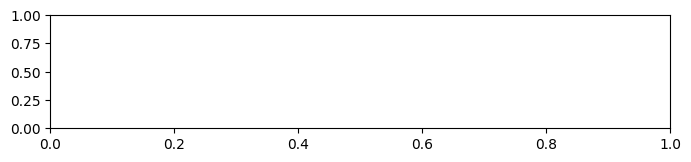

In [378]:
plot_training(data_res, e_tot)
performance_plots(e_tot, time_axis, gbest_history, multiruns=False)

In [331]:
# Stability analysis

def reward_stability(algorithm, no_runs, no_bin, iterations):
    rewards = []
    times = []
    gbests = np.zeros((iterations+1, no_runs))
    time_matrix = np.zeros((iterations+1,))
    
    for i in range(no_runs):
        if algorithm == ArtificialBeeColony:
                best_policy, best_reward, gbest_history, time_axis = algorithm(lower_bound=-5, upper_bound=5, no_employed=50, no_onlooker=round(25), iterations=iterations, distance_value=1, scout_limit=2)
        elif algorithm == ParticleSwarm:
            best_policy, best_reward, gbest_history, time_axis = algorithm(lower_bound=-5, upper_bound=5, no_particles=round(50), inertia=0.6, cognitive=0.2, social=0.2, regime=None, tmax=iterations)
        elif algorithm == GeneticSearch:
            best_policy, best_reward, gbest_history, time_axis = algorithm(lower_bound=-5, upper_bound=5, mutation_rate=0.35, iterations=iterations, sample_size=55)
        elif algorithm == Firefly:
            best_policy, best_reward, gbest_history, time_axis = algorithm(lower_bound=-5, upper_bound=5, no_fireflies=round(10), iterations=iterations, attractiveness=0.8, absorption=0, randomness=0.2)
        elif algorithm == SimulatedAnnealing:
            best_policy, best_reward, gbest_history, time_axis = algorithm(lower_bound=-5, upper_bound=5, initial_accept_prob=0.4, max_iterations=iterations+1, step_size=0.4, temp_regime='log')
        else:
            print("Invalid algorithm")
        gbest_time = time_axis[gbest_history.index(best_reward)]
        rewards.append(best_reward)
        times.append(gbest_time)
        gbests[:, i] = np.array(gbest_history)
        # print(time_axis)
        time_matrix = np.array(time_axis)
        
    # Plot a histogram of the rewards with the mean and standard deviation
    plt.hist(rewards, bins = no_bin, edgecolor = 'black')
    performance_plots(50, time_matrix, gbests, multiruns=True)
    plt.xlabel('Reward')
    plt.ylabel('Frequency')
    plt.title('Stability of the reward')
    plt.show()
        
    
    return rewards, times

In [332]:
stability = reward_stability(algorithm= ParticleSwarm, no_runs = 10, no_bin = 20, iterations=50)

Iteration 0
Iteration 1
Iteration 2
Iteration 3


KeyboardInterrupt: 

In [ ]:
# hyperparameter tuning - with skopt
# Work in progress!
pso_space = {"no_particles": Integer(1,100), "inertia": Real(0,1), "cognitive": Real(0,1), "social": Real(0,1), "tmax": Integer(1,100)}

def pso_algorithm():
    best_policy, best_reward, gbest_history, time_axis = ParticleSwarm(lower_bound=-5, upper_bound=5, no_particles=50, inertia=0.6, cognitive=0.04, social=0.36, tmax=50)
    return best_reward

opt = BayesSearchCV(pso_algorithm, pso_space, optimizer_kwargs={'base_estimator': 'GP'}, n_iter=10, random_state=42)
optimizer.fit(None)
best_params = optimizer.best_params_
print("Best Parameters:", best_params)





NameError: name 'Integer' is not defined

In [ ]:
def hpp_search(lower1, upper1, num1, lower2, upper2, num2, algorithm):
    best_rewards = {'coordinates': [], 'values': []}
    times_taken = {'coordinates': [], 'values':[]}
    var1_range = np.linspace(lower1, upper1, num=num1)
    var2_range = np.linspace(lower2, upper2, num=num2)
    var1_coords = []
    var2_coords = []
    
    # var1 = ratio of onlooker to employed
    # var2 = scout limit

    for v1 in var1_range:
        for v2 in var2_range:
            if algorithm == ArtificialBeeColony:
                best_policy, best_reward, gbest_history, time_axis = algorithm(lower_bound=-5, upper_bound=5, no_employed=25, no_onlooker=round(25*v1), iterations=50, distance_value=1, scout_limit=v2) 
            elif algorithm == ParticleSwarm:
                best_policy, best_reward, gbest_history, time_axis = algorithm(lower_bound=-5, upper_bound=5, no_particles=round(v1), inertia=v2, cognitive=0.04, social=0.36, tmax=50)
            elif algorithm == GeneticSearch:
                best_policy, best_reward, gbest_history, time_axis = algorithm(lower_bound=-5, upper_bound=5, mutation_rate=v1, iterations=50, sample_size=v2)
            elif algorithm == Firefly:
                best_policy, best_reward, gbest_history, time_axis = algorithm(lower_bound=-5, upper_bound=5, no_fireflies=round(v1), iterations=50, attractiveness=0.8, absorption=0, randomness=0.2)
            elif algorithm == SimulatedAnnealing:
                best_policy, best_reward, gbest_history, time_axis = algorithm(lower_bound=-5, upper_bound=5, initial_accept_prob=v1, max_iterations=500, step_size=v2, temp_regime='log')
            else:
                print("Invalid algorithm")
            gbest_time = time_axis[gbest_history.index(best_reward)]
            time_taken = time_axis[-1]
            best_rewards['coordinates'].append((v1, v2))
            times_taken['coordinates'].append((v1, v2))
            best_rewards['values'].append(best_reward)
            times_taken['values'].append(gbest_time)
            var1_coords.append(v1)
            var2_coords.append(v2)

    var1_coords = np.array(var1_coords)
    var2_coords = np.array(var2_coords)
       
    np_times = np.array(times_taken['values'])
    np_rewards = np.array(best_rewards['values'])

    shortest_time = np_times.argmin()
    lowest_reward = np_rewards.argmin()

    shortest_hpp = {'mutation rate': times_taken['coordinates'][shortest_time][0], 'sample size': times_taken['coordinates'][shortest_time][1]}
    best_hpp = {'mutation rate': best_rewards['coordinates'][lowest_reward][0], 'sample_size': best_rewards['coordinates'][lowest_reward][1]}

    time_efficiencies = np_times * np_rewards
    most_efficient = time_efficiencies.argmin()

    efficient_hpp = {'mutation rate': times_taken['coordinates'][most_efficient][0], 'sample size': times_taken['coordinates'][shortest_time][1]}

    max_time = np.max(np_times)
    min_time = np.min(np_times)
    max_reward = np.max(np_rewards)
    min_reward = np.min(np_rewards)

    X = (np_times - min_time) / (max_time - min_time)
    Y = (np_rewards - min_reward) / (max_reward - min_reward)
    # X, Y = np.meshgrid(X,Y)
    Z = (X+1) * (Y+1) - 1
    print(shortest_hpp)
    print(best_hpp)
    print(efficient_hpp)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Create a scatter plot in 3D with vmin and vmax
    scatter = ax.scatter(var1_coords, var2_coords, Z, cmap=cm.coolwarm, vmin=np.min(Z), vmax=np.max(Z))

    # Set the limits for the Z-axis
    ax.set_zlim(-1, 4)

    # Configure tick locators for the Z-axis
    ax.zaxis.set_major_locator(LinearLocator(10))

    # Add a color bar which maps values to colors
    colorbar = fig.colorbar(scatter, shrink=0.5, aspect=5)

    colorbar.set_label('Time efficiencies')

    # Set labels for the axes
    ax.set_xlabel('Mutation Rates')
    ax.set_ylabel('Sample Sizes')
    ax.set_zlabel('Time efficiencies')

    plt.show()
    
    return shortest_hpp, best_hpp, efficient_hpp




Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Iteration 60
Iteration 61
Iteration 62
Iteration 63
Iteration 64
Iteration 65
Iteration 66
Iteration 67
Iteration 68
Iteration 69
Iteration 70
Iteration 71
Iteration 72
Iteration 73
Iteration 74
Iteration 75
Iteration 76
Iteration 77
Iteratio

/var/folders/qq/j7gysh0d1x54nchfxgzn4lb40000gn/T/ipykernel_22398/3348308178.py:69: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = ax.scatter(var1_coords, var2_coords, Z, cmap=cm.coolwarm, vmin=np.min(Z), vmax=np.max(Z))


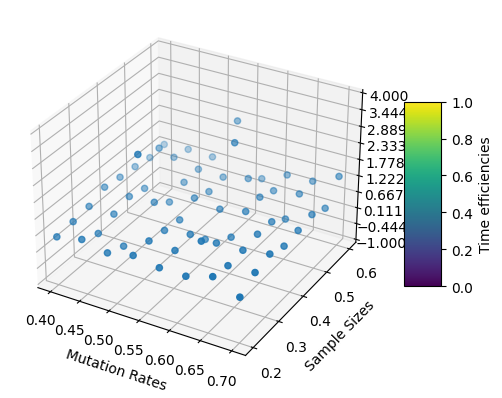

In [ ]:
#bestbestreward = best_rewards['values'][lowest_reward]
#print(best_rewards['coordinates'])
#print(best_rewards['values'])
#print(times_taken['values'])
shortest_hpp, best_hpp, efficient_hpp = hpp_search(lower1=0.4, upper1=0.7, num1=8, lower2=0.2, upper2=0.6, num2=8, algorithm=SimulatedAnnealing)

Notice that the 'input size' below has an extra +2. This is because we must pass the information to the policy network about the setpoint (given that our setpoint will change). Therefore, we give 2 extra inputs to our policy network, one for each setpoint.

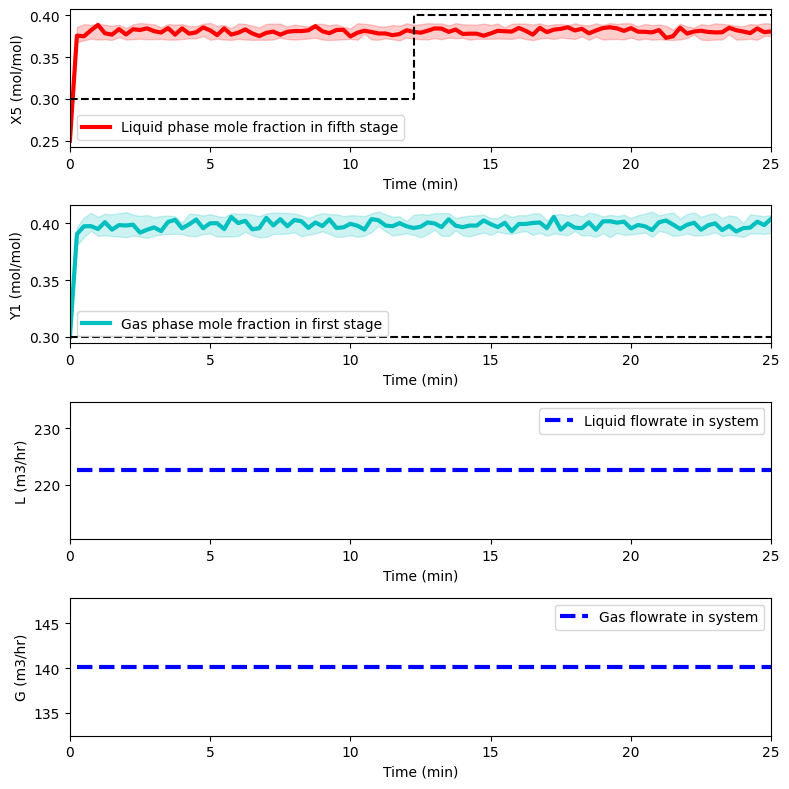

In [373]:
nx            = 10
nu            = 2
hyparams      = {'input_size': nx+2, 'output_size': nu} # include setpoints +2
policy_net_SPS_RL = Net(**hyparams, requires_grad=True, retain_graph=True)
policy_net_SPS_RL.load_state_dict(best_policy)

reps = 10

# X1_eval = np.zeros((data_res['X1_dat'].shape[0], reps))
# X2_eval = np.zeros((data_res['X2_dat'].shape[0], reps))
# X3_eval = np.zeros((data_res['X3_dat'].shape[0], reps))
# X4_eval = np.zeros((data_res['X4_dat'].shape[0], reps))
X5_eval = np.zeros((data_res['X5_dat'].shape[0], reps))

Y1_eval = np.zeros((data_res['Y1_dat'].shape[0], reps))
# Y2_eval = np.zeros((data_res['Y2_dat'].shape[0], reps))
# Y3_eval = np.zeros((data_res['Y3_dat'].shape[0], reps))
# Y4_eval = np.zeros((data_res['Y4_dat'].shape[0], reps))
# Y5_eval = np.zeros((data_res['Y5_dat'].shape[0], reps))

L_eval = np.zeros((data_res['L_dat'].shape[0], reps))
G_eval = np.zeros((data_res['G_dat'].shape[0], reps))

for r_i in range(reps):
  X5_eval[:,r_i], Y1_eval[:,r_i], L_eval[:,r_i], G_eval[:,r_i] = J_PolicyDIST(policy_net_SPS_RL,
                                                               policy_alg='SPS_RL', 
                                                                collect_training_data=False, 
                                                                traj=True) 

# , X1_eval[:,r_i], X2_eval[:,r_i], X3_eval[:,r_i], X4_eval[:,r_i], Y2_eval[:,r_i], Y3_eval[:,r_i], Y4_eval[:,r_i], Y5_eval[:,r_i]
  
# Plot the results
plot_simulation(X5_eval, Y1_eval, L_eval, G_eval, data_res)

# X1_eval, X2_eval, X3_eval, X4_eval, Y2_eval, Y3_eval, Y4_eval, Y5_eval,

### Remarks on stochastic policy search

As it can be observed from the simple example above Stochastic local search methods work well in practice and are much easier to implement that other techniques (such as policy gradients). In general, as we move to large parameter spaces, for example neural networks with millions of parameters, their performance will deteriorate, and a policy gradient-like approach will be more desireable. 

## Policy Gradients 🗻

Policy gradient methods rely on the [Policy Gradient Theorem](https://link.springer.com/article/10.1007/BF00992696) which allows to retrieve the gradient of the expected objective function with respect to policy parameters (neural network weights) $\nabla_\theta \mathbb{E}_{\pi_\theta}[f(\pi_\theta)]$ through Monte Carlo runs. Given the availability of gradients, it is possible to follow a gradient-based optimization to optimize the policy, generally, Adam or Gradient Descent is used. More information can be found of Chapter 13 on [Reinforcement Learning: An Introduction](http://incompleteideas.net/book/the-book.html). 

In this tutorial notebook we outline the simplest algorithm of this kind, **Reinforce**. For a more in dept introduction to the topic see [Intro to Policy Optimization](https://spinningup.openai.com/en/latest/spinningup/rl_intro3.html).

In the case of stochastic policies, the policy function returns the defining parameters of a probability distribution (such as the mean and variance) over possible actions, from which the actions are sampled: 
$$\textbf{u} \sim \pi_\theta(\textbf{u} | \textbf{x}) = \pi(\textbf{u} | \textbf{x}, \theta) = p(\textbf{u} | \textbf{x}, \theta)$$

Note*: this is the same as the stochastic policy introduced earlier, following the 'probability notation'.

To learn the optimal policy, we seek to maximize our performance metric, and hence we can follow a gradient ascent strategy: 
$$\theta_{m+1} = \theta_m + \alpha_m \nabla_\theta \mathbb{E}_{\pi_\theta}[f(\pi_\theta)] $$

where $m$ is the current iteration that the parameters are updated (epoch), $\nabla_\theta \mathbb{E}_{\pi_\theta}[f(\pi_\theta)]$ is the expectation of $f$ over $\pi_\theta$ and $\alpha_m$ is the step size (also termed learning rate in the RL community) for the $m^{th}$ iteration. 

Computing $ \nabla_\theta \hat{f}(\theta) = \nabla_\theta\mathbb{E}_{\pi_\theta}[J(\pi_\theta)]$ directly is difficult, therefore we use the Policy Gradient Theorem, which shows the following:


$$ \begin{alignat}{3}
\nabla_\theta\hat{f}(\theta) = \nabla_\theta \mathbb{E}_{\pi_\theta}[f(\pi_\theta)] &~=~\nabla_\theta \int  p(\pi_\theta|\theta)~ f(\pi_\theta)\text{d}\pi_\theta\\
&~=~\int \nabla_\theta p(\pi_\theta|\theta)~ f(\pi_\theta) \text{d}\pi_\theta\\
&~=~\int p(\pi_\theta|\theta) ~ \frac{\nabla_\theta p(\pi_\theta|\theta)}{p(\pi_\theta|\theta)~} ~ f(\pi_\theta) \text{d}\pi_\theta\\
&~=~\int p(\pi_\theta|\theta) ~ \nabla_\theta \text{log}\left( p(\pi_\theta|\theta)\right) f(\pi_\theta)\text{d}\pi_\theta\\
&~=~\mathbb{E}_{\pi_\theta} \left[ f(\pi_\theta) \nabla_\theta \text{log}\left( p(\pi_\theta|\theta)\right) \right]
\end{alignat} $$

Notice from the first expression, that, $p(\pi_\theta|\theta)~ f(\pi_\theta)$ is an objective function value multiplied by its probability density, therefore, integrating this over all possible values of $\pi_\theta$ we obtain the expected value. From there, using simple algebra, logarithms and the chain rule, we arrive at the final equations, which shows an expected value, where, dropping the explicit distribution of $\pi_\theta$, gives us an unbiased gradient estimator, our steepest ascent update now becomes:

$$ \theta_{m+1} = \theta_m + \alpha_m \mathbb{E}_{\pi_\theta}\left[ f(\pi_\theta) \nabla_\theta \text{log}\left( p(\pi_\theta|\theta)\right) \right] 
$$

Using the expression for $p(\pi_\theta|\theta) = \hat{\mu}(\textbf{x}_0) \prod_{t=0}^{T-1} \left[\pi(\textbf{u}_t|\textbf{x}_t,\theta) p(\textbf{x}_{t+1}|\textbf{x}_t,\textbf{u}_t) \right]$ and taking its logarithm, we obtain:

$$\nabla_\theta \text{log}\left( p(\pi_\theta|\theta)\right) = \nabla_\theta \sum_{t=0}^{T-1} \text{log}\left( \pi(\textbf{u}_t|\textbf{x}_t,\theta)\right)$$

Note that since $p(\textbf{x}_{t+1}|\textbf{x}_t,\textbf{u}_t)$ and $\hat{\mu}(\textbf{x}_0)$ are independent of $\theta$ they disappear from the above expression. Then we can rewrite for a trajectory as:

$$\nabla_\theta \mathbb{E}_{\pi_\theta}[f(\pi_\theta)] = \mathbb{E}_{\pi_\theta} \left[ f(\pi_\theta) \nabla_\theta \sum_{t=0}^{T-1} \text{log}\left( \pi(\textbf{u}_t|\textbf{x}_t,\theta)\right)\right]$$

The above expression does not require the knowledge of the dynamics of the physical system. Monte-Carlo method is utilized to approximate the expectation.

$$\nabla_\theta \mathbb{E}_{\pi_\theta}[f(\pi_\theta)] \approx \frac{1}{K} \sum_{k=1}^{K} \left( f(\pi_\theta) \nabla_\theta \sum_{t=0}^{T-1} \text{log}\left( \pi(\textbf{u}_t|\textbf{x}_t,\theta)\right)\right)$$


**Reinforce algorithm**

${\bf Input:}$ Initialize policy parameter $\theta = \theta_0$, with $\theta_0\in\Theta_0$, learning rate $\alpha$, set number of episodes $K$ and number of epochs $N$.

${\bf Output:}$ policy $\pi(\cdot | \cdot ,\theta)$ and $\Theta$
\smallskip

${\bf for}$ $m = 1,\dots, N$ ${\bf do}$


1.   Collect $\textbf{u}_t^k , \textbf{x}_t^k,f(\pi_\theta^k)$ for $K$ trajectories of $T$ time steps.
2.   Estimate the gradient $ \hat{g}_m := \frac{1}{K} \sum_{k=1}^{K}  \left[ f(\pi_\theta^k) \nabla_\theta \sum_{t=0}^{T-1} \text{log}\left( \pi(\textbf{u}_t^k|\hat{\textbf{x}}_t^k,\theta)\right)\right]$
3.   Update the policy using a policy gradient estimate $\theta_{m+1} = \theta_m + \alpha_m \hat{g}_m$
4.   $m:=m+1$

${\bf Remark}$: The above algorithm is the base version for many further developments that have been made since it was first proposed. 

The steps of the algorithm are explained below:

${\bf Initialization:}$ The policy network and its weights $\theta$ are initialized along with the algorithm's hyperparameters such as learning rate, number of episodes and number of epochs.

${\bf Training ~~ loop:}$ The weights of the policy network are updated by a policy gradient scheme for a total of $N$ epochs. 

In ${\bf Step 1}$ $K$ trajectories are computed, each trajectory consists of $T$ time steps, and states and control actions are collected. 

In ${\bf Step 2}$ the gradient of the objective function with respect to the weights for the policy network is computed. 

In ${\bf Step 3}$ the weights of the policy network are updated by a gradient ascent scheme. Note that here we show a steepest ascent-like update, but other first order (i.e. Adam) or trust region methods can be used (i.e. PPO, TRPO). 

In ${\bf Step 4}$, either the algorithm terminates or returns to Step 1.

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch import Tensor
from torch.distributions import MultivariateNormal

In order to implement and apply the Reinforce algorithm, we are going to perform the following steps in the following subsections:


*   Create a [policy network](#policy_net) that uses transfer learning
*   Create an auxiliary function that selects [control actions](#control_actions) out of the distribution
*   Create an auxilary function that runs [multiple episodes](#multi_episodes) per epoch
*   Finally, put all the pieces together into a function that computes the [Reinforce algorithm](#r_alg)



<a name="policy_net"></a>
### Policy network


In the next section of this tutorial notebook we show an implementation from scratch of a policy optimization algorithm using policy gradients.

Given that we have already optimized the policy via stochastic search in the previous section, we use those parameters as a starting point for policy gradients. This is a form of [transfer learning](https://en.wikipedia.org/wiki/Transfer_learning#:~:text=Transfer%20learning%20(TL)%20is%20a,when%20trying%20to%20recognize%20trucks.), which refers to applying knowledge that was previously gained while solving one task to a related task. 

Related to this transfer learning process, we will create a second neural network with the exact same configuration as before, but we will add an extra node to each output of the original neural network to account for the variance term. This is because previously our neural network policy had the structure:

$${\bf u}:=\pi({\bf x};\boldsymbol{\theta})$$

and by a Stochastic search algorithm we manipulated the weights $\boldsymbol{\theta}$ to optimize performance. In policy gradients we output a distribution, rathen than a single value, in this case we output the mean and the variance of a normal distribution (each output now has two values, the mean and the variance), and therefore we must add an extra node to each output such that we have:

$$ \boldsymbol{ \mu }, \boldsymbol{ \Sigma } := \pi({\bf x};\boldsymbol{\theta})$$

$${\bf u} \sim \mathcal{N}(\boldsymbol{ \mu }, \boldsymbol{ \Sigma })$$



In [ ]:
#########################################
# Policy Network with transfer learning #
#########################################

class Net_TL(torch.nn.Module):
  # in current form this is a linear function (wouldn't expect great performance here)
  def __init__(self, **kwargs):
    super(Net_TL, self).__init__()

    self.dtype    = torch.float

    # Unpack the dictionary 
    self.args     = kwargs

    # Get info of machine
    self.use_cuda = torch.cuda.is_available() 
    self.device   = torch.device("cpu")

    # Define ANN topology 
    self.input_size = self.args['input_size']
    self.output_sz  = self.args['output_size']
    self.hs1        = self.input_size*2
    self.hs2        = self.output_sz*2 

    # Define layers 
    self.hidden1 = torch.nn.Linear(self.input_size, self.hs1 )
    self.hidden2 = torch.nn.Linear(self.hs1, self.hs2)
    self.output  = torch.nn.Linear(self.hs2, self.output_sz)

  def forward(self, x):
    #x = torch.tensor(x.view(1,1,-1)).float() # re-shape tensor
    x = x.view(1, 1, -1).float()
    y = Ffunctional.leaky_relu(self.hidden1(x), 0.1)
    y = Ffunctional.leaky_relu(self.hidden2(y), 0.1)
    y = Ffunctional.relu6(self.output(y))   # range (0,6)

    return y

  def increaseClassifier(self, m:torch.nn.Linear):
    w         = m.weight
    b         = m.bias
    old_shape = m.weight.shape

    m2        = nn.Linear( old_shape[1], old_shape[0] + 1)
    m2.weight = nn.parameter.Parameter( torch.cat( (m.weight, m2.weight[0:1]) ), 
                                       requires_grad=True )
    m2.bias   = nn.parameter.Parameter( torch.cat( (m.bias, m2.bias[0:1]) ), 
                                       requires_grad=True)
    return m2
  
  def incrHere(self): 
    self.output = self.increaseClassifier(self.output)

Notice that just as before, we ad a +2 to the input, as thisrefers to the current set-point value.

In [ ]:
nx            = 2
nu            = 1
hyparams      = {'input_size': nx+2, 'output_size': nu} # include setpoints +2

policy_net_pg = Net_TL(**hyparams, requires_grad=True, retain_graph=True)
policy_net_pg.load_state_dict(best_policy) # Transfer learning
policy_net_pg.incrHere()

RuntimeError: Error(s) in loading state_dict for Net_TL:
	Unexpected key(s) in state_dict: "hidden3.weight", "hidden3.bias". 
	size mismatch for hidden1.weight: copying a param with shape torch.Size([24, 12]) from checkpoint, the shape in current model is torch.Size([8, 4]).
	size mismatch for hidden1.bias: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for hidden2.weight: copying a param with shape torch.Size([24, 24]) from checkpoint, the shape in current model is torch.Size([2, 8]).
	size mismatch for hidden2.bias: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([2]).
	size mismatch for output.weight: copying a param with shape torch.Size([2, 4]) from checkpoint, the shape in current model is torch.Size([1, 2]).
	size mismatch for output.bias: copying a param with shape torch.Size([2]) from checkpoint, the shape in current model is torch.Size([1]).

<a name="control_actions"></a>
### Control action selection


In [ ]:
################################
# action selection from Normal #
################################

def select_action(control_mean, control_sigma):
    """
    Sample control actions from the distribution their distribution
    input: Mean, Variance
    Output: Controls, log_probability, entropy
    """
    s_cov          = control_sigma.diag()**2
    dist           = MultivariateNormal(control_mean, s_cov)
    control_choice = dist.sample()                 # sample control from N(mu,std)
    log_prob       = dist.log_prob(control_choice) # compute log prob of this action (how likely or unlikely)
    entropy        = dist.entropy()                # compute the entropy of the distribution N(mu, std)
    
    return control_choice, log_prob, entropy

#########################
# un-normalizing action #
#########################

def mean_std(m, s, mean_range=[10], mean_lb=[295], std_range=[0.001]):
    '''
    Problem specific restrictions on predicted mean and standard deviation.
    '''
    mean = Tensor(mean_range) * m/6 + Tensor(mean_lb) # ReLU6
    std  = Tensor(std_range)  * s/6
    
    return mean, std

<a name="multi_episodes"></a>
### Multiple episodes - one epoc/training step


In [ ]:
################
# one epoc run #
################

def epoc_run(NNpolicy, episodes_n):
    '''This function runs episodes_n episodes and collected the data. This data
    is then used for one gradient descent step.

    INPUTS
    NNpolicy:   the NN policy
    episodes_n: number of episodes per epoc (gradient descent steps)
    data_train: dictionary of data collected

    OUTPUTS
    data_train: collected data to be passed to the main training loop
    '''

    # run episodes
    logprobs_list = [] # log probabilities is the policies itself p(a|s)
    reward_list   = [] # reward
    for epi_i in range(episodes_n):
        reward_, sum_logprob = J_PolicyCSTR(NNpolicy, policy_alg='PG_RL', 
                                            collect_training_data=True, episode=True)
        logprobs_list.append(sum_logprob)
        reward_list.append(reward_)

    # compute mean and expectation of rewards
    reward_m   = np.mean(reward_list)
    reward_std = np.std(reward_list)
    

    # compute the baseline (reverse sum)
    log_prob_R = 0.0
    for epi_i in reversed(range(episodes_n)):
        baselined_reward = (reward_list[epi_i] - reward_m) / (reward_std + eps)
        log_prob_R       = log_prob_R - logprobs_list[epi_i] * baselined_reward

    # mean log probability
    mean_logprob = log_prob_R/episodes_n
    reward_std   = reward_std
    reward_m     = reward_m

    return mean_logprob, reward_std, reward_m 

<a name="r_alg"></a>
### Reinforce algorithm

Now, let's create a function that put all pieces together and implements the Reinforce algorithm explained above

In [ ]:
def Reinforce(policy, optimizer, n_epochs, n_episodes):

    # lists for plots
    rewards_m_record = []; rewards_std_record = []

    for epoch_i in range(n_epochs):

        # collect data
        mean_logprob, reward_std, reward_m = epoc_run(policy, n_episodes)

        # Expected log reward 
        E_log_R = mean_logprob
        optimizer.zero_grad()
        E_log_R.backward()
        optimizer.step()

        # save data for analysis
        rewards_m_record.append(reward_m)
        rewards_std_record.append(reward_std)

        # schedule to reduce lr
        scheduler.step(E_log_R)

        if epoch_i%int(n_epochs/10)==0:
            mean_r = reward_m
            std_r  = reward_std
            print('epoch:', epoch_i)
            print(f'mean reward: {mean_r:.3} +- {std_r:.2}')

    return rewards_m_record, rewards_std_record, policy

### Apply the Reinforce algorithm

Now that we have the algorithm, let's apply it to the problem. 

Let's choose some problem parameters and initialize storing lists

In [ ]:
# problem parameters
lr         = 0.0001
total_it   = 2000
n_episodes = 50
n_epochs   = int(total_it/n_episodes)

# data for plots
data_res['Ca_train']    = []; data_res['T_train']     = [] 
data_res['Tc_train']    = []; data_res['err_train']   = []
data_res['u_mag_train'] = []; data_res['u_cha_train'] = []

define the policy and the optimizer to be used

In [ ]:
# define policy and optimizer
control_policy = policy_net_pg
optimizer_pol  = optim.Adam(control_policy.parameters(), lr=lr)

define the learning rate scheduler

In [ ]:
# Define Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_pol, factor=0.5, patience=10, verbose=True, min_lr=0.000001,
    cooldown = 10)

and apply the algorithm

```{note} Runing the algorithm will last for a few minutes
```

In [ ]:
rewards_m_record, rewards_std_record, optimal_Reinforce = \
Reinforce(control_policy, optimizer_pol, n_epochs, n_episodes)

/var/folders/qq/j7gysh0d1x54nchfxgzn4lb40000gn/T/ipykernel_18911/3967602739.py:76: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Tc[i]                     = u_k


epoch: 0
mean reward: -23.7 +- 0.82
epoch: 4
mean reward: -23.5 +- 0.69
epoch: 8
mean reward: -23.7 +- 0.77
epoch: 12
mean reward: -23.9 +- 0.82
epoch: 16
mean reward: -23.9 +- 0.92
Epoch 00019: reducing learning rate of group 0 to 5.0000e-05.
epoch: 20
mean reward: -23.6 +- 1.1
epoch: 24
mean reward: -23.5 +- 0.95
epoch: 28
mean reward: -23.6 +- 0.98
epoch: 32
mean reward: -23.4 +- 0.89
epoch: 36
mean reward: -23.4 +- 0.86
Epoch 00040: reducing learning rate of group 0 to 2.5000e-05.


Let's visualize now

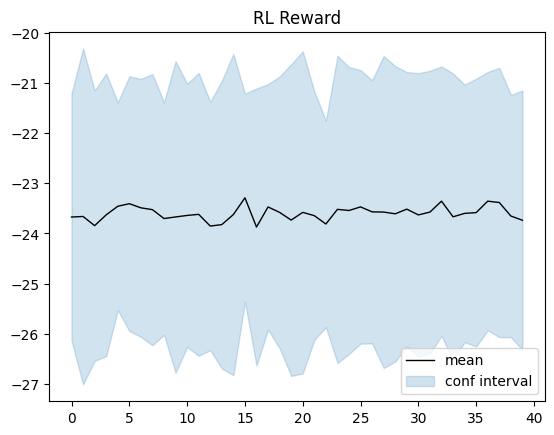

In [ ]:
# plot the samples of posteriors
plt.plot(rewards_m_record, 'black', linewidth=1)
# plot GP confidence intervals
iterations = [i for i in range(len(rewards_m_record))]
plt.gca().fill_between(iterations, np.array(rewards_m_record) - 3*np.array(rewards_std_record), 
                       np.array(rewards_m_record) + 3*np.array(rewards_std_record), 
                       color='C0', alpha=0.2)
plt.title('RL Reward')
plt.legend(('mean', 'conf interval'),
           loc='lower right')
plt.show()

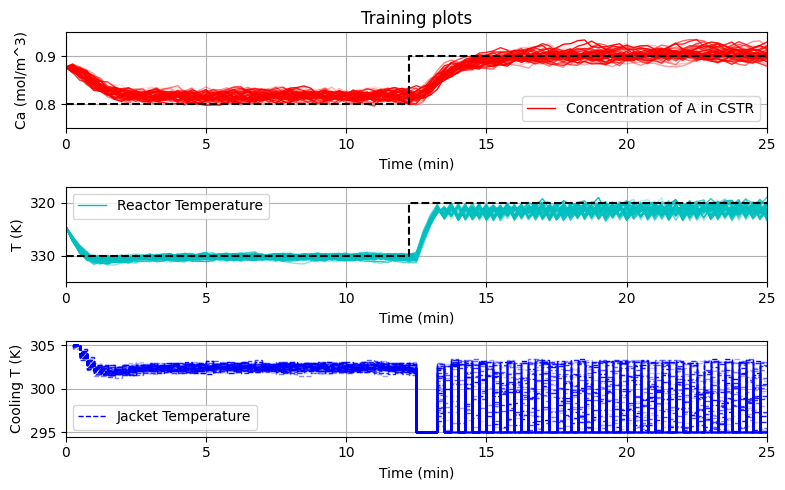

In [ ]:
plot_training(data_res, e_tot)

/var/folders/qq/j7gysh0d1x54nchfxgzn4lb40000gn/T/ipykernel_18911/3967602739.py:76: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Tc[i]                     = u_k


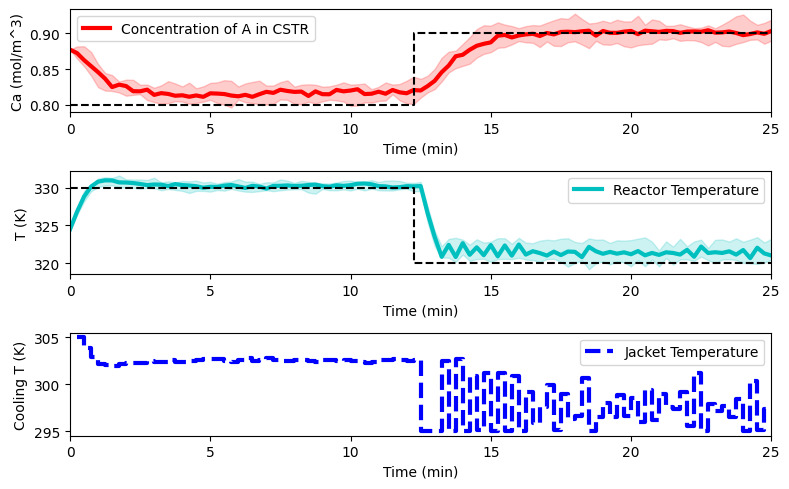

In [ ]:
reps = 10

Ca_eval = np.zeros((data_res['Ca_dat'].shape[0], reps))
T_eval = np.zeros((data_res['T_dat'].shape[0], reps))
Tc_eval = np.zeros((data_res['Tc_dat'].shape[0], reps))

for r_i in range(reps):
  Ca_eval[:,r_i], T_eval[:,r_i], Tc_eval[:,r_i] = J_PolicyCSTR(policy_net_pg,
                                                               policy_alg='PG_RL', 
                                                                collect_training_data=False, 
                                                                traj=True)
# Plot the results
plot_simulation(Ca_eval, T_eval, Tc_eval, data_res)

## Extra material on RL for ChemEng 🤓

If you would like to read more about the use of reinforcement learning in chemical engineering systems:

**Applications** 

*   Reinforcement learning offers potential for bringing significant improvements to [industrial batch process control practice](https://www.sciencedirect.com/science/article/abs/pii/S136757882100081X) even in [discontinous and nonlinear systems](https://www.sciencedirect.com/science/article/abs/pii/S0098135419304168).
*   RL has also been used to address [chemical production scheduling](https://www.sciencedirect.com/science/article/pii/S0098135420301599) and [multi-echelon supply chains](https://www.sciencedirect.com/science/article/pii/S2772508122000643)
*   Other applications include [PID tuning](https://www.sciencedirect.com/science/article/abs/pii/S0967066121002963), [real-time optimization](https://www.mdpi.com/2227-9717/11/1/123), [searching for optimal process routes](https://www.sciencedirect.com/science/article/abs/pii/S0098135420303999), [flowsheet generation](https://aiche.onlinelibrary.wiley.com/doi/full/10.1002/aic.17938), [bioreactors](https://www.sciencedirect.com/science/article/abs/pii/S0098135419304168) and [biotherapeutics](https://onlinelibrary.wiley.com/doi/10.1002/bit.28346), amongst many others.

**Methodologies** 

*   Constraints to address [plant-model mismatch](https://www.sciencedirect.com/science/article/abs/pii/S0098135421004087), [constrained Q-learning](https://www.sciencedirect.com/science/article/abs/pii/S0098135421002404), [safe reinforcement learning](https://www.researchgate.net/publication/368302457_Safe_deployment_of_reinforcement_learning_using_deterministic_optimization_of_trained_neural_networks), satisfaction of constraints with [high probability](https://www.sciencedirect.com/science/article/pii/S0959152422000038), and [dynamic penalties](https://www.sciencedirect.com/science/article/pii/S0959152422000816) for better convergence.
*   [Process control](https://www.mdpi.com/2227-9717/10/11/2311), [meta-reinforcement learning](https://www.sciencedirect.com/science/article/pii/S0959152422001445), [general economic process control](https://www.sciencedirect.com/science/article/pii/S0098135420307912), amongst many many others. 

 